In [122]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import itertools
import dill
import abc_etc
import evo_etc

In [123]:
# Convenient pickle wrappers
def load_pickle(filename):
    return dill.load(open(file=filename,mode='rb'))
        
def dump_pickle(obj,filename):
    return dill.dump(obj=obj,file=open(file=filename, mode='wb'))

### Toy example

In [124]:
# This solution is really ugly, but I cannot see another easy way to solve this problem
def simulator(candidate):
    # There is really nothing to similate in this toy example, so we just return the answer
    return candidate

def fitness_function(dummy,candidate):
    denomenator = 1+((candidate["x"]-1)**2+(candidate["y"]-1)**2)*((candidate["x"]+1)**2+(candidate["y"]+1)**2)
    R2 = 1/denomenator
    return -R2

def extract_bayesian_final_generation(model: abc_etc.SMCABC ,population_size=128):
    particles_to_pick = np.argsort(model.all_distances)[:population_size]
    return [model.all_particles[particle] for particle in particles_to_pick]

def extract_evolution_final_generation(model: evo_etc.CrowdingDE):
    particles_to_pick = model.population[-1]
    return [model.all_particles[particle] for particle in particles_to_pick]
    




outdir = "../results/toy_example"
n_simulations = 4
toy_example_results = pd.DataFrame(index=pd.MultiIndex.from_product([["Bayesian","Evolutionary"],range(n_simulations)],names=["Method","Simulation"])).reset_index()
toy_example_results["modelfile"] = list(itertools.starmap(lambda method,simulation: f"{'bayesian' if method == 'Bayesian' else 'crowdingDE'}_{simulation}.pkl",
                                                      toy_example_results[["Method","Simulation"]].itertuples(index=False,name=None)))
toy_example_results["model"] = list(map(lambda filename: load_pickle(f"{outdir}/{filename}"),toy_example_results["modelfile"]))
toy_example_results["final_generation"] = list(itertools.starmap(lambda method, model: (extract_bayesian_final_generation if method == "Bayesian" else extract_evolution_final_generation)(model),
                                              toy_example_results[["Method","model"]].itertuples(index=False,name=None)))
toy_example_results.set_index(["Method","Simulation"],inplace=True)


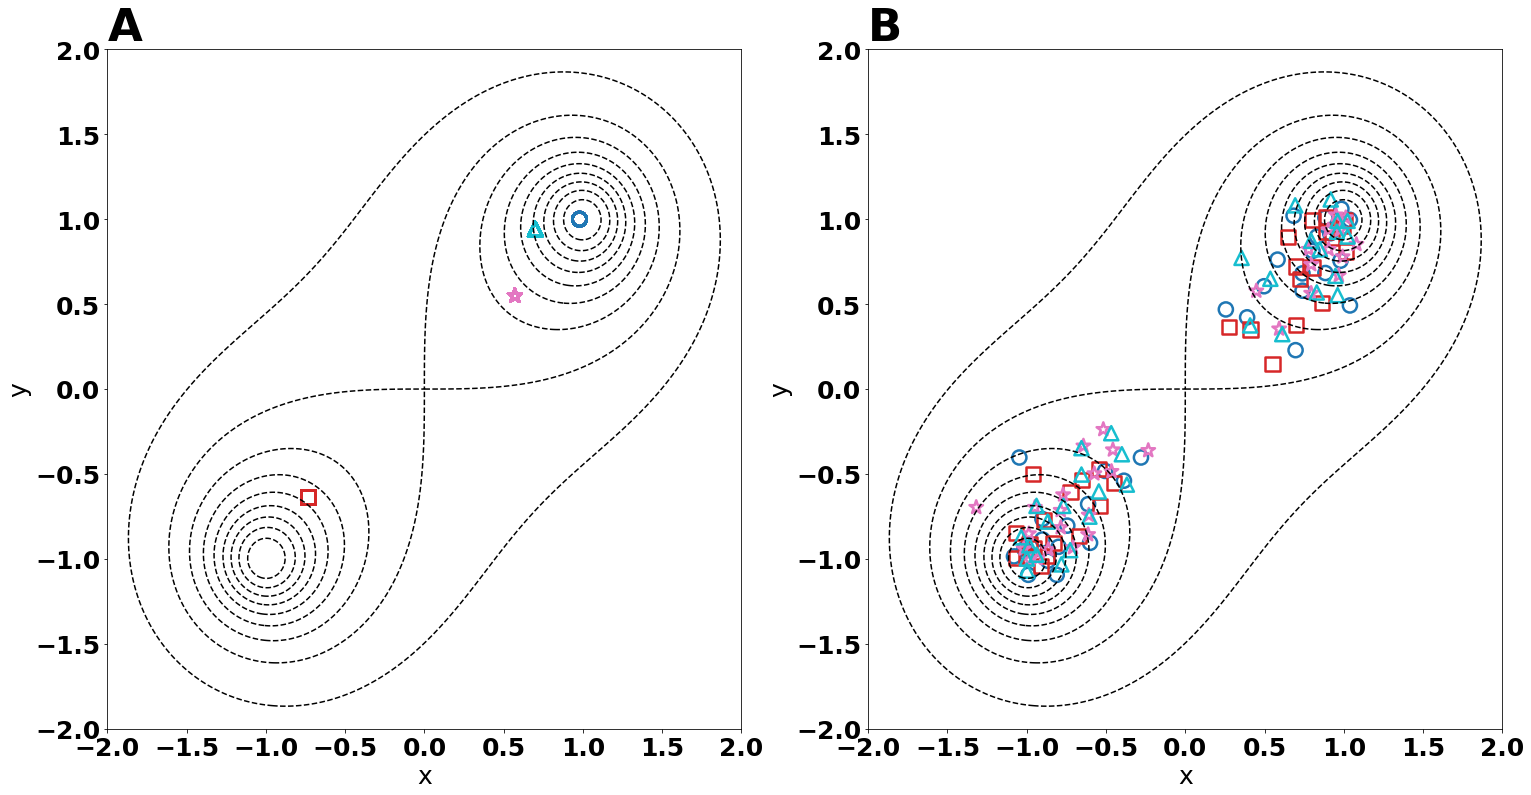

In [129]:
def contour_function(x,y):
    denomenator = 1+((x-1)**2+(y-1)**2)*((x+1)**2+(y+1)**2)
    R2 = 1/denomenator
    return -R2

plt.figure(figsize=(2*12.5,12.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)
def plot_population(particles,simulation=0):
    cmap = matplotlib.cm.get_cmap('tab10',n_simulations)
    markers = ["o","s","*", "^"]
    x,y = zip(*[(particle["x"],particle["y"]) for particle in particles])
    plt.scatter(x,y,s=200,alpha=1,facecolors="none",edgecolors=cmap(simulation),marker=markers[simulation % 4],linewidths=2.5)
    plt.xlim((-2,2))
    plt.ylim((-2,2))
    plt.xlabel("x")
    plt.ylabel("y")


for i, method in enumerate(["Bayesian","Evolutionary"],start=0):
    plt.subplot(1,2,i+1)
    X, Y = np.meshgrid(np.linspace(-2,2,1000),np.linspace(-2,2,1000))
    Z = contour_function(X,Y)
    plt.contour(X,Y,Z,10,colors="black")
    plt.title(["A","B"][i],loc="left",fontsize=45,fontweight="bold")
    for j, simulation in enumerate(toy_example_results.loc[method].index):
        plot_population(toy_example_results.loc[(method,simulation),"final_generation"],j)
plt.savefig("../figures/toy_example.png",dpi=300)
plt.show()


### Load data for Bayesian calculation method with full data and permuted priors

In [131]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/distance_frame.pkl")

In [132]:
model_frame = model_skeleton.set_index(["origin","status"])

In [133]:
reference_distances = model_frame.loc[("unpermuted","original"),"all_distances"]

In [134]:
distances = model_frame["all_distances"]

In [135]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [136]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [137]:
combined_df_metadata = load_pickle("../results/permuted_smcabc_res/combined_df_metadata.pkl")

In [138]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


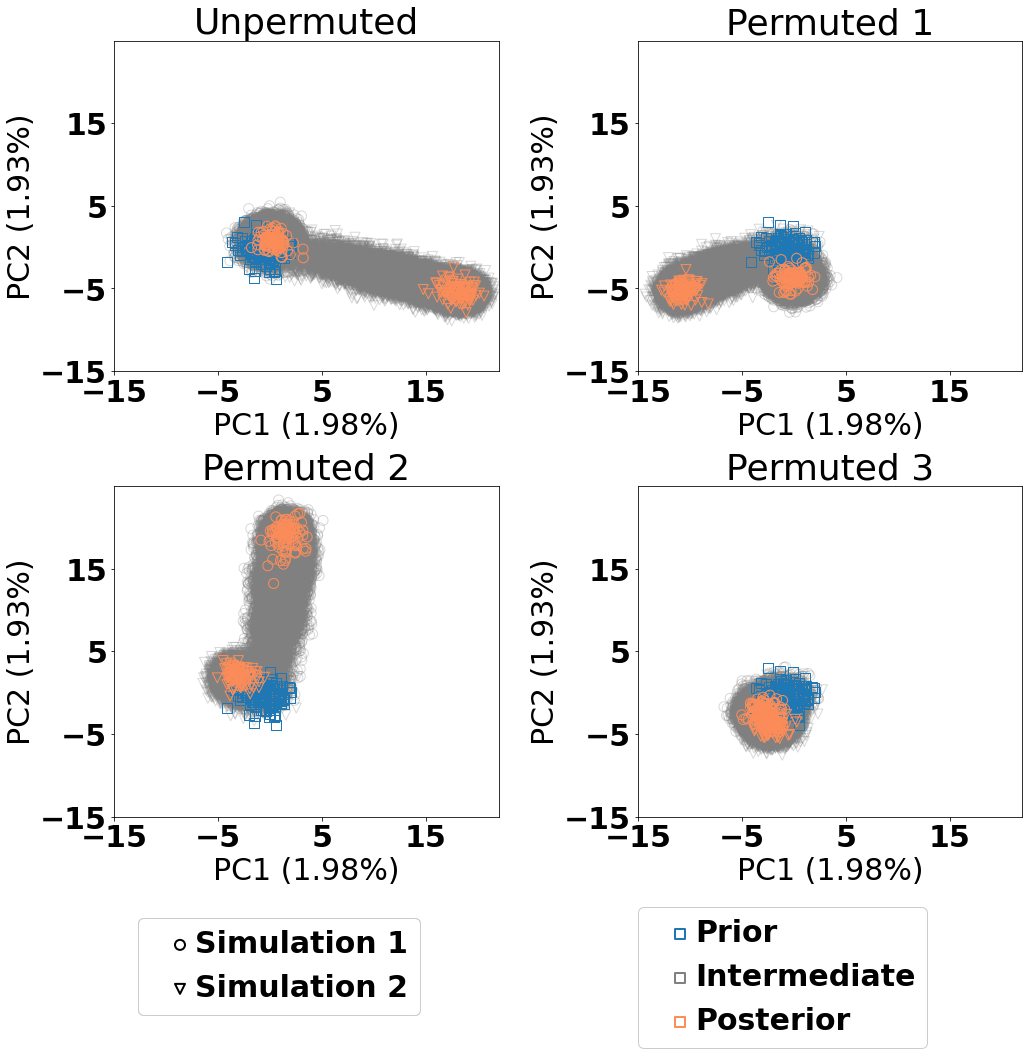

In [144]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(len(this_idxs["Intermediate"]),100000),replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100000),replace=False)
        print(label_idxs.shape)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-15,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-15,22))
    plt.ylim((-15,25))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

In [145]:
this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}

In [146]:
len(this_idxs["Posterior"])

5938

## $R^2$ convergence plots

In [150]:
def plot_convergence_inner(distances, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    r2s_history = -np.array(distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(distances):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

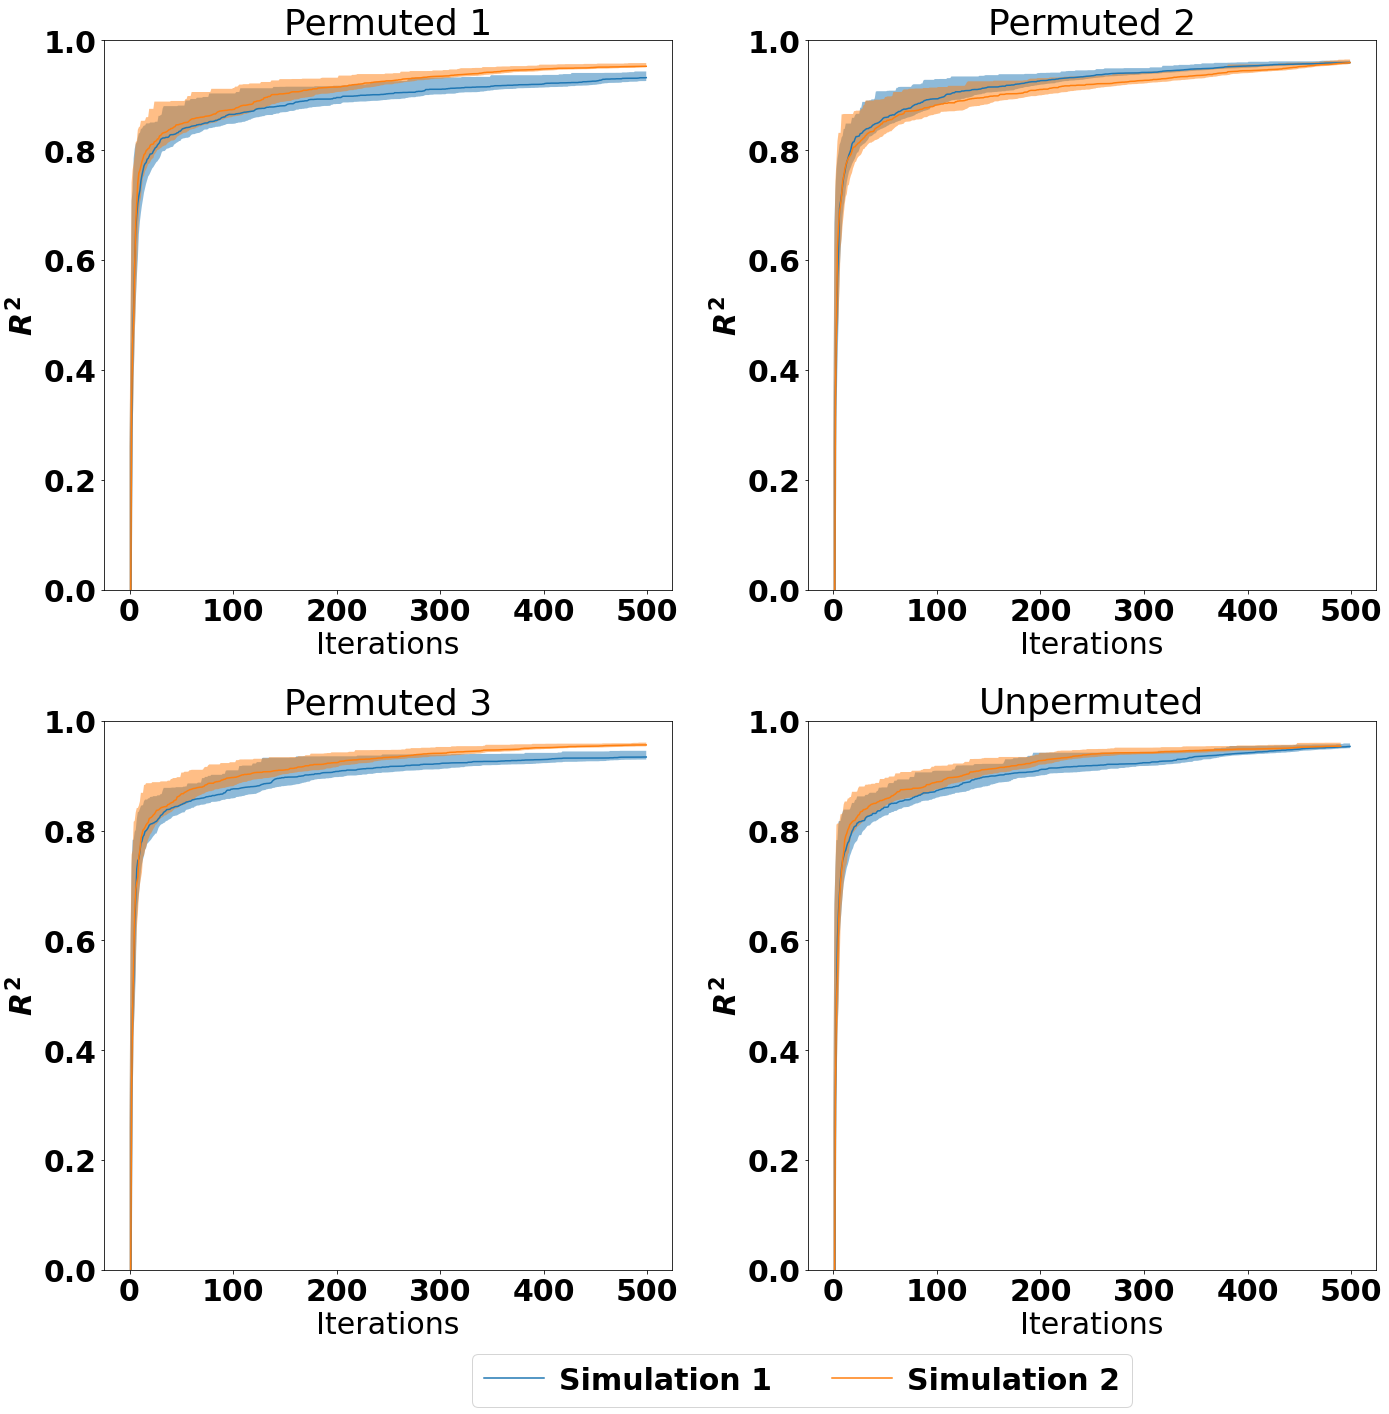

In [36]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
# plt.savefig("../figures/R2.pdf")
plt.show()

## Create integrated plot for Unpermuted and Permuted 1

In [149]:
reduced_pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_reduced_ordination.pkl")

In [152]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
plt.figure(figsize=(20,20))
i=2
for index, series in model_frame.query("origin in ('unpermuted','permuted_0')")["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==1:
        plt.legend(loc="lower right",handletextpad=0.5)
        # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title("A" if index=="unpermuted" else "B",loc="left",fontsize=45,fontweight="bold")
    i -= 1
    plt.tight_layout()
    
PCS, EV = reduced_pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
i=3
for origin in ["unpermuted","permuted_0"]:
    plt.subplot(2,2,i)    
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(len(this_idxs["Intermediate"]),100000),replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100000),replace=False)
        print(label_idxs.shape)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,20))
    plt.title("C" if origin=="unpermuted" else "D",loc="left",fontsize=45,fontweight="bold")
    if origin == "unpermuted":
        legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
        plt.gca().add_artist(legend_period)
    else:
        legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="lower right", framealpha=1,handletextpad=-.5)
        plt.gca().add_artist(legend_status)
    plt.tight_layout()

plt.savefig("../figures/bayesian_fig.png",dpi=300)
plt.show()

(63139,)
(61724,)
(62675,)
(62990,)


## Effects on pathway level

In [88]:
aggregated_fva_res = load_pickle("../results/aggregated_fva_res.pkl")

In [89]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

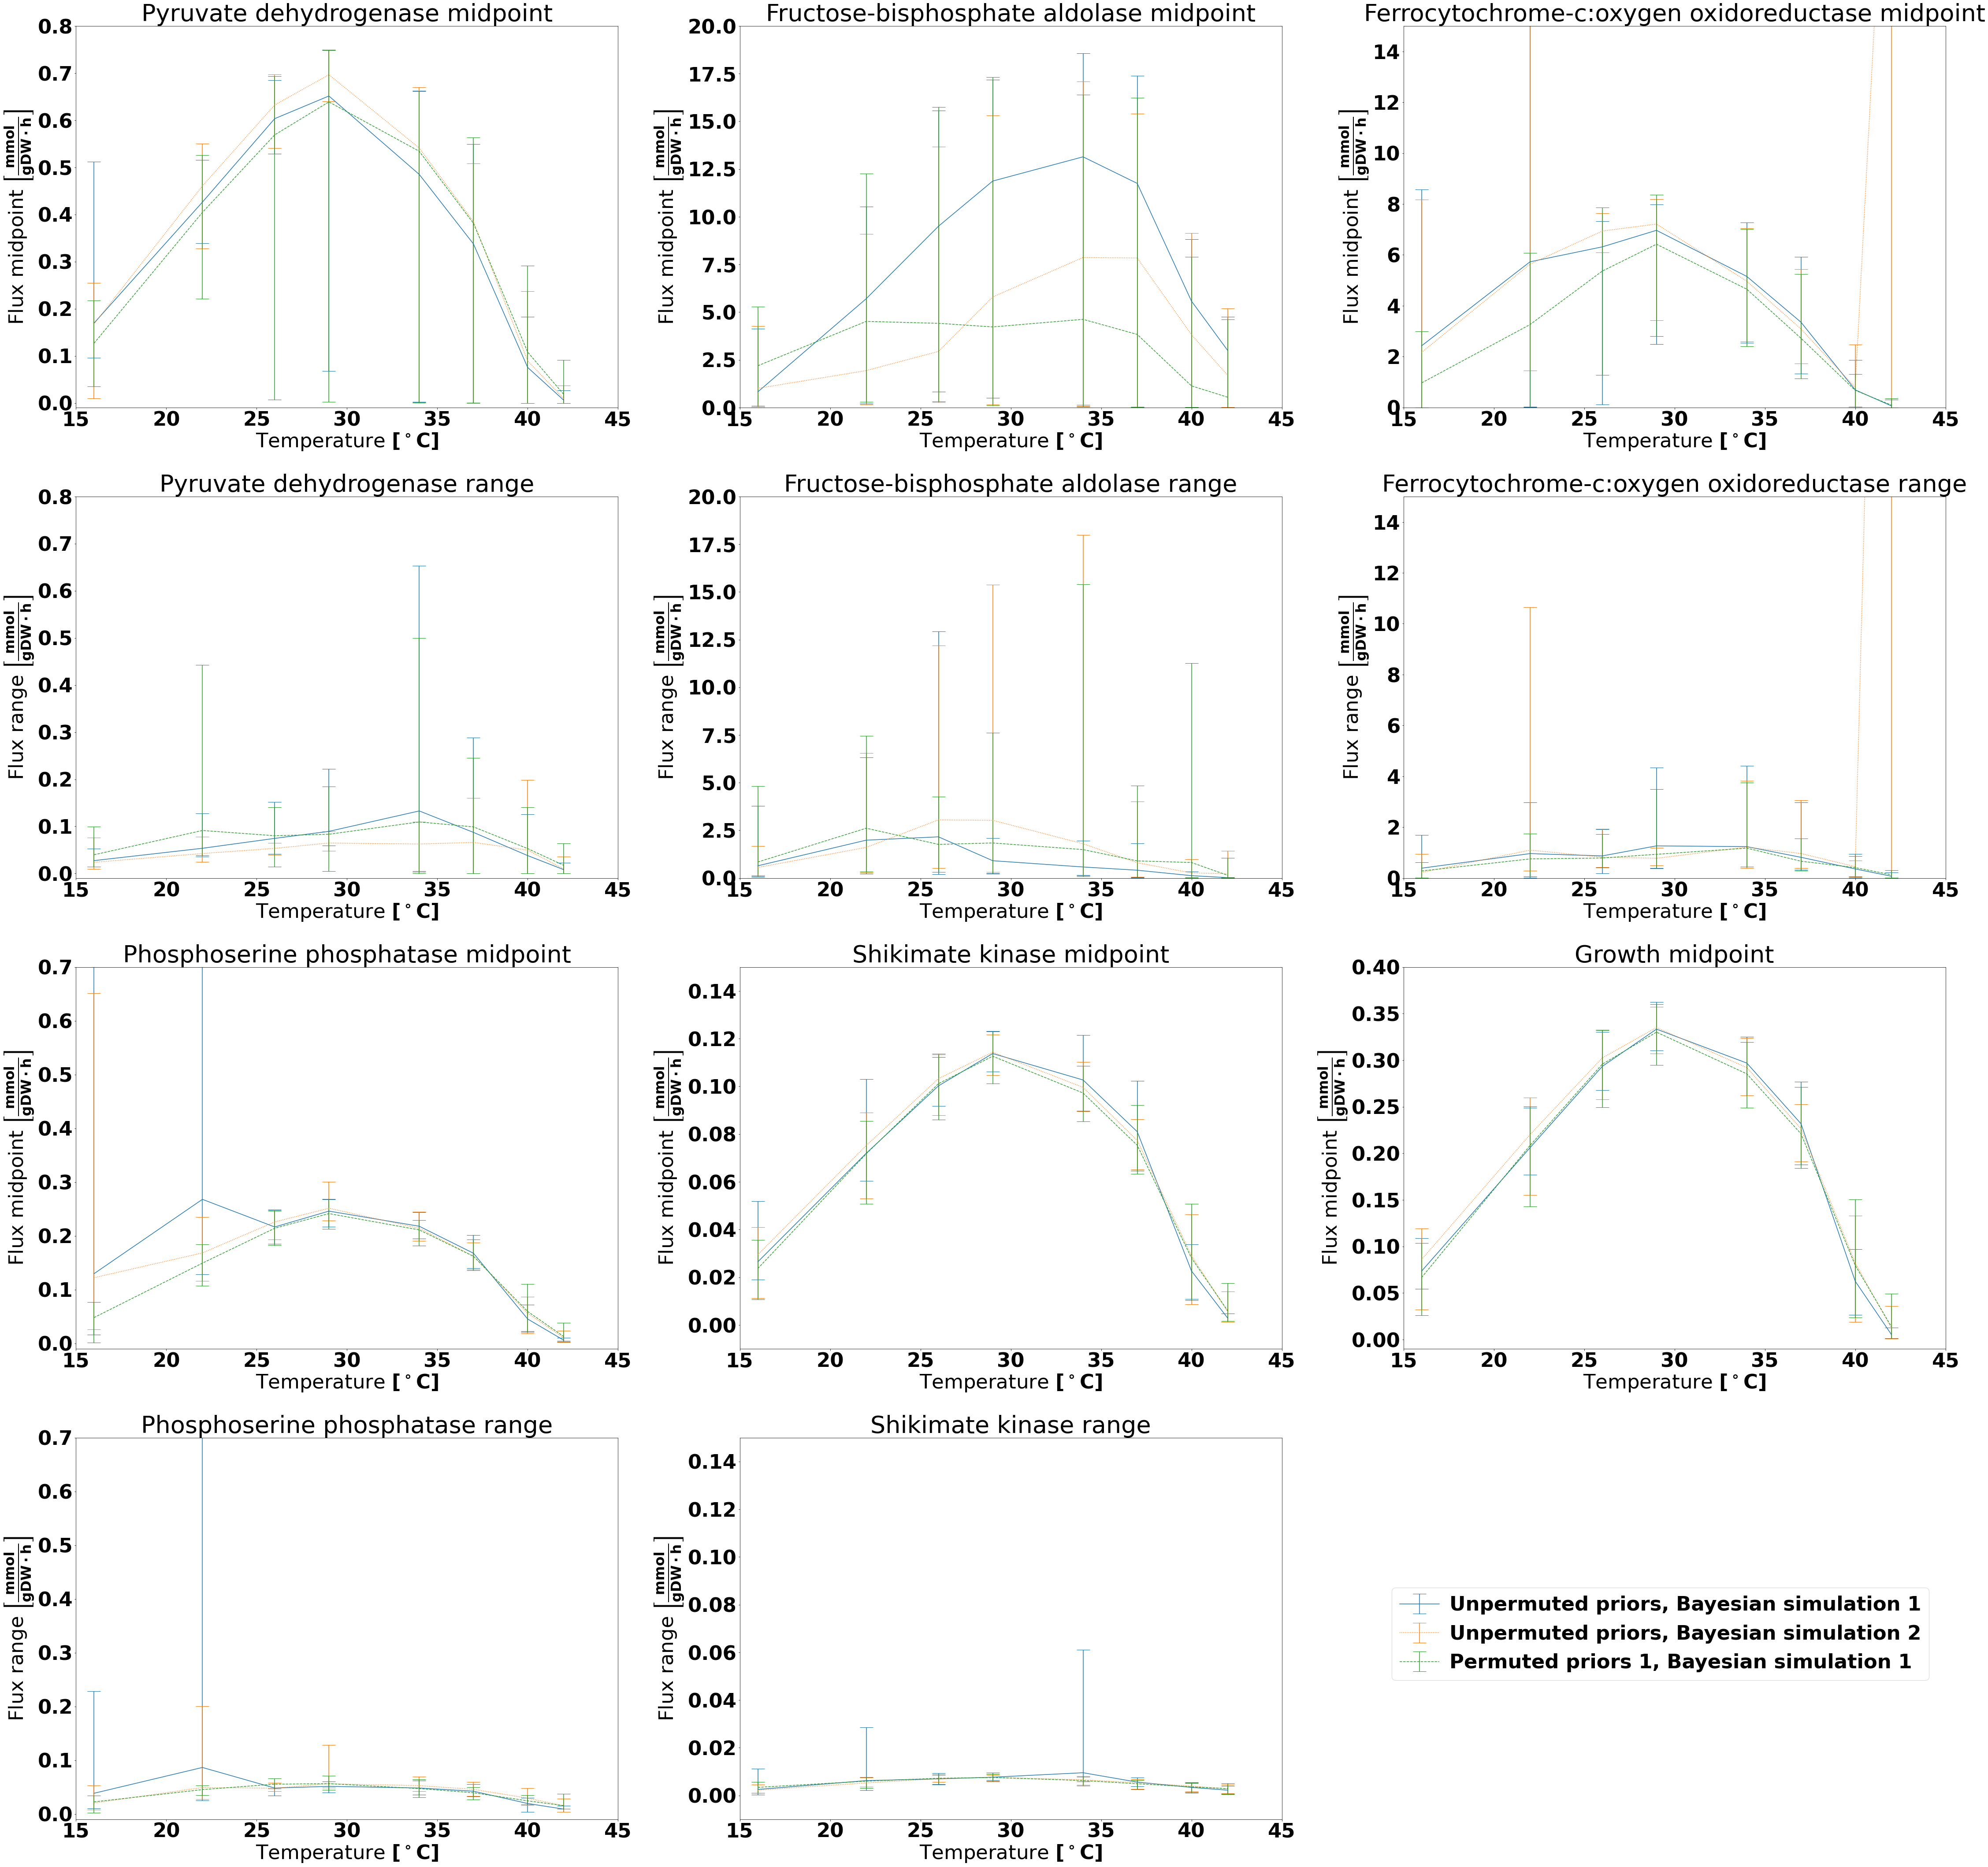

In [90]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/aerobic_fva.pdf")

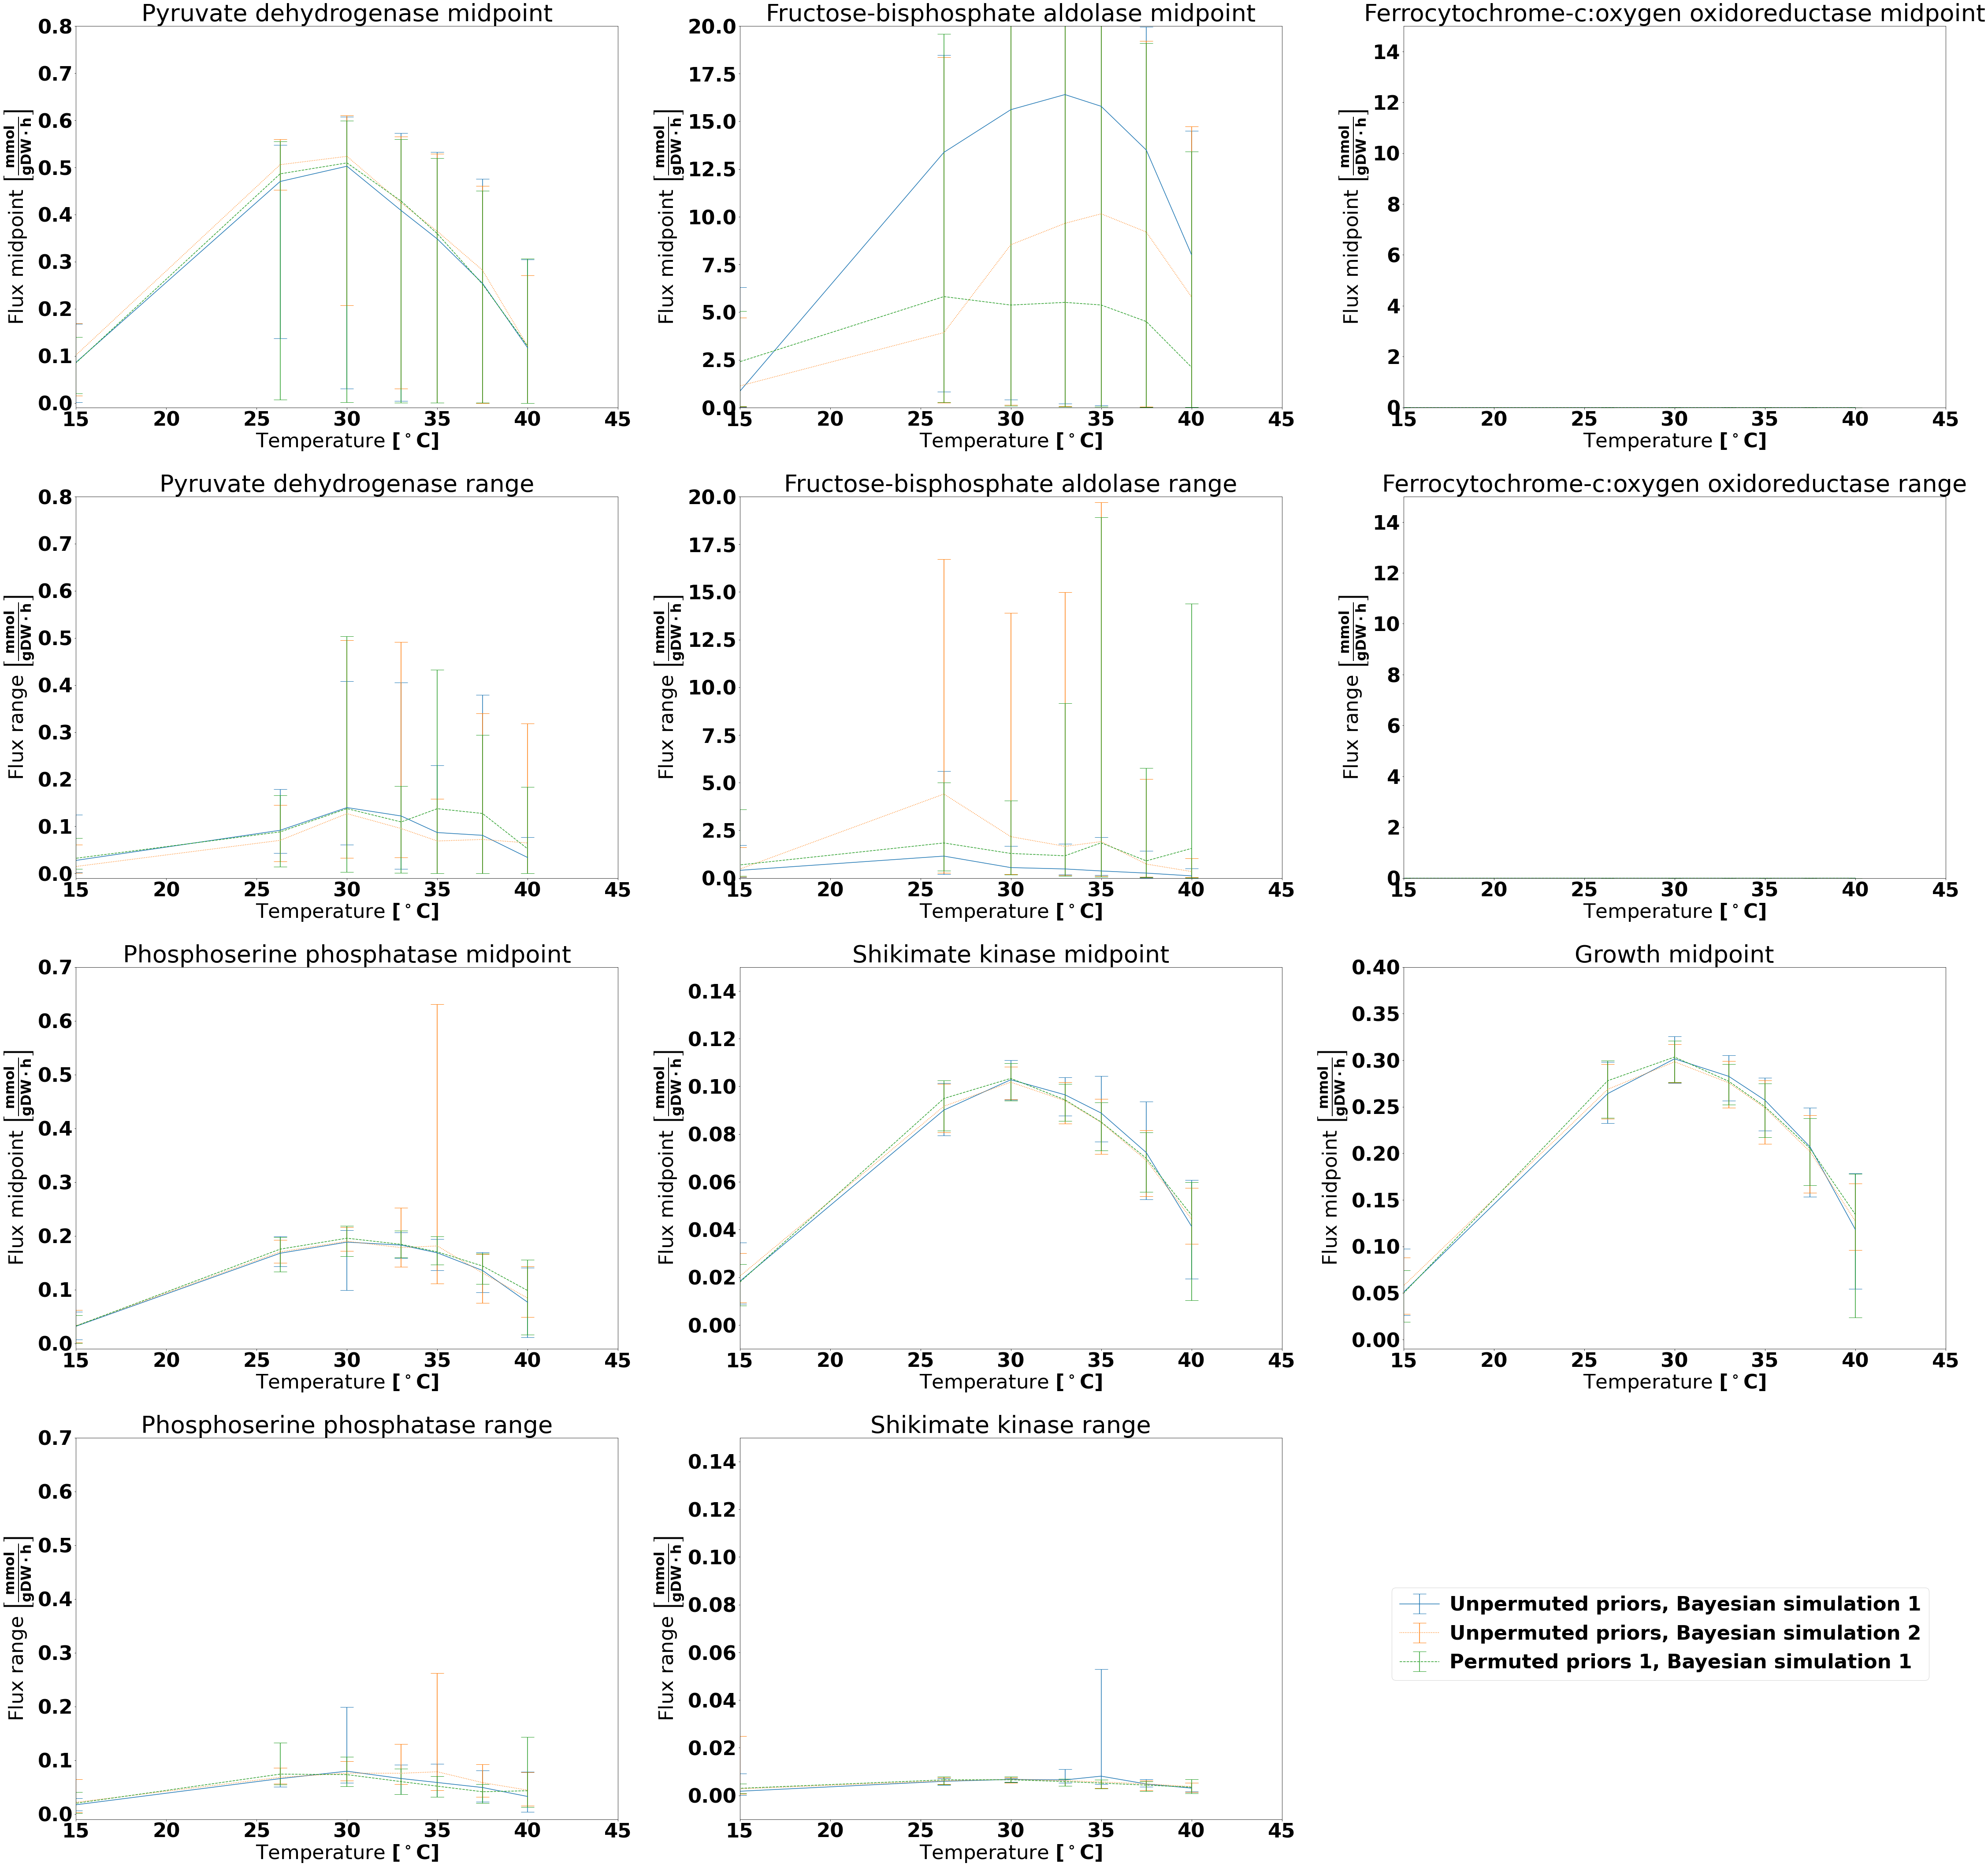

In [92]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="anaerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="anaerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="anaerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/anaerobic_fva.pdf")

# Results for Bayesian calculation method with chemostat dataset withheld

## Loading data

In [153]:
model_skeleton = load_pickle("../results/reduced_smcabc_res/distance_frame.pkl")

In [154]:
model_frame = model_skeleton.set_index(["simulation"])

In [155]:
reference_distances = model_frame.loc[0,"all_distances"]

In [156]:
distances = model_frame["all_distances"]

In [157]:
!pwd

/home/jakobpp/BayesianGEM/code


## $R^2$ curves

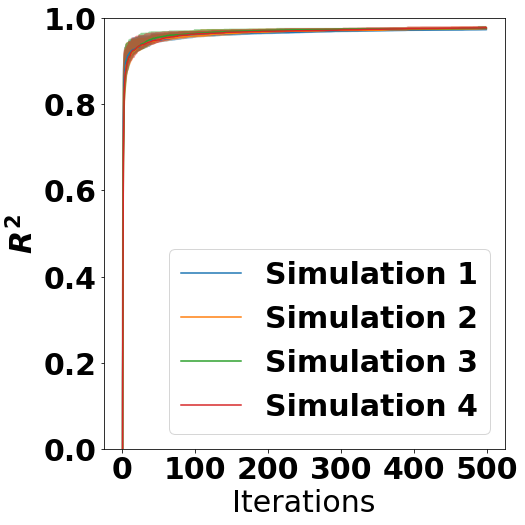

In [158]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
maxiter = 500
plt.figure(figsize=(8,8))
for simulation, entry in model_frame.iterrows():
    distances = entry["all_distances"]
    # plt.subplot(2,2,i)
    plot_convergence_inner(distances,maxiter=500,label=f"Simulation {simulation+1}")
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.xticks(np.arange(0,501,100))
    plt.tight_layout()
plt.legend()
plt.savefig("../figures/reduced_R2.png",dpi=300)
plt.show()

In [159]:
combined_df_metadata = load_pickle("../results/reduced_smcabc_res/combined_df_metadata.pkl")
pca_ordination = load_pickle("../results/reduced_smcabc_res/pca_full_ordination.pkl")

(61690,)
(62618,)
(61880,)
(62405,)


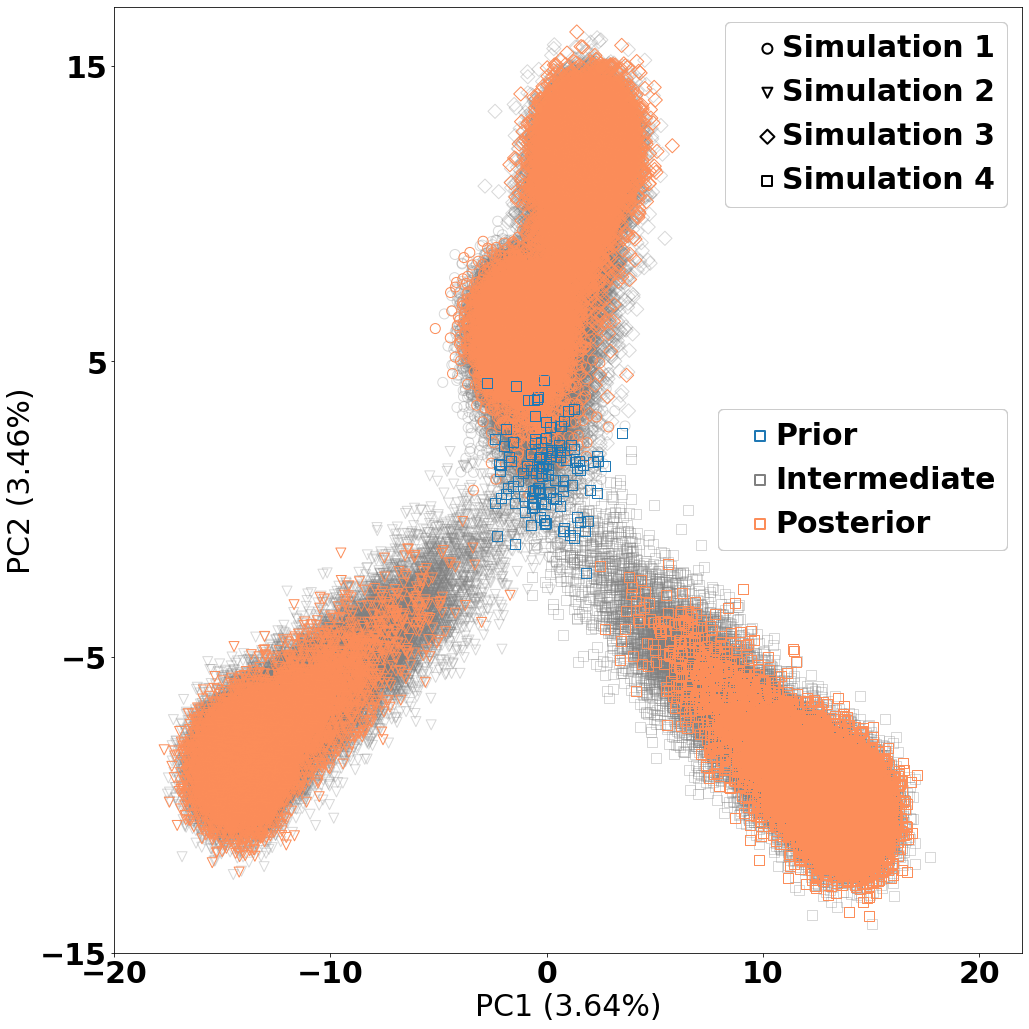

In [164]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
marker_dict = {0: 'o', 1: "v", 2: "D", 3: "s"}
plt.figure(figsize=(15,15))
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
simulation = combined_df_metadata["simulation"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
    
PCS, EV = pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_simulation = [f(marker, "k") for marker in marker_dict.values()]
for i in range(4):
    label_idxs = np.nonzero(i == simulation)[0]
    marker = marker_dict[i]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(len(this_idxs["Intermediate"]),100000),replace=False)
    this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100000),replace=False)
    print(label_idxs.shape)
    plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
    
for i in range(4):
    label_idxs = np.nonzero(i == simulation)[0]
    marker = marker_dict[i]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(len(this_idxs["Intermediate"]),100000),replace=False)
    this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100000),replace=False)
    
    plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    if i==0:
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker="s",facecolors='none',s=100)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,17))
    legend_status = plt.legend(handles_simulation, [f"Simulation {i+1}" for i in range(4)], loc="upper right", framealpha=1,handletextpad=-.5)
    plt.gca().add_artist(legend_status)
    legend_period = plt.legend(handles_period, all_periods, loc="right", framealpha=1, handletextpad=-.5)
    plt.gca().add_artist(legend_period)
    plt.tight_layout()
plt.savefig("../figures/reduced_pca.png",dpi=300)
plt.show()

## FVA results

In [13]:
def aggregate_fva_results(result_df,simulation_attributes):
    flattened_df_list = []
    for _, row in result_df.drop(columns=["particle"]).iterrows():
        raw_df = row["fva_res"]
        df = raw_df
        for attribute in simulation_attributes:
            df[attribute] = row[attribute]
        flattened_df_list.append(df)

    combined_fva_frame = (
        pd.concat(flattened_df_list).
        assign(range= lambda df: df["maximum"] - df["minimum"],
                                                            midpoint= lambda df: (df["maximum"] + df["minimum"]) / 2).
        drop(columns=["minimum", "maximum"])
            )
    simulation_attributes.extend(["condition","reaction","T"])
    aggregated_fva_res = (
        combined_fva_frame.replace([np.inf, -np.inf],np.nan).
        dropna(how="all").
        groupby(simulation_attributes).
        agg(["mean","min","max","std","count"])
                        )
    return aggregated_fva_res

In [59]:
aggregated_fva_res = load_pickle("../results/reduced_aggregated_fva_res.pkl")

In [12]:
aggregated_fva_res

range                   midpoint      \
                                        mean min max std count     mean min   
simulation condition reaction   T                                             
0          aerobic   NGAM       315.15   NaN NaN NaN NaN     0      NaN NaN   
                     arm_r_0001 315.15   NaN NaN NaN NaN     0      NaN NaN   
                     arm_r_0002 315.15   NaN NaN NaN NaN     0      NaN NaN   
                     arm_r_0004 315.15   NaN NaN NaN NaN     0      NaN NaN   
                     arm_r_0005 315.15   NaN NaN NaN NaN     0      NaN NaN   
...                                      ...  ..  ..  ..   ...      ...  ..   
3          anaerobic r_4043     278.15   NaN NaN NaN NaN     0      NaN NaN   
                     r_4043_REV 278.15   NaN NaN NaN NaN     0      NaN NaN   
                     r_4044     278.15   NaN NaN NaN NaN     0      NaN NaN   
                     r_4044_REV 278.15   NaN NaN NaN NaN     0      NaN NaN   
                     r_4045No1  278.15   NaN NaN NaN NaN     0      NaN NaN   

                                                      
                                       max std count  
simulation condition reaction   T                     
0          aerobic   NGAM       315.15 NaN NaN     0  
                     arm_r_0001 315.15 NaN NaN     0  
                     arm_r_0002 315.15 NaN NaN     0  
                     arm_r_0004 315.15 NaN NaN     0  
                     arm_r_0005 315.15 NaN NaN     0  
...                                     ..  ..   ...  
3          anaerobic r_4043     278.15 NaN NaN     0  
                     r_4043_REV 278.15 NaN NaN     0  
                     r_4044     278.15 NaN NaN     0  
                     r_4044_REV 278.15 NaN NaN     0  
                     r_4045No1  278.15 NaN NaN     0  

[40806 rows x 10 columns]

In [62]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

In [84]:
aggregated_fva_res = load_pickle("../results/reduced_aggregated_fva_res.pkl")
aggregated_fva_res.reset_index(inplace=True)
aggregated_fva_res = aggregated_fva_res[np.isin(aggregated_fva_res.reaction.to_numpy(),np.array(list(signature_reactions.values())))]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


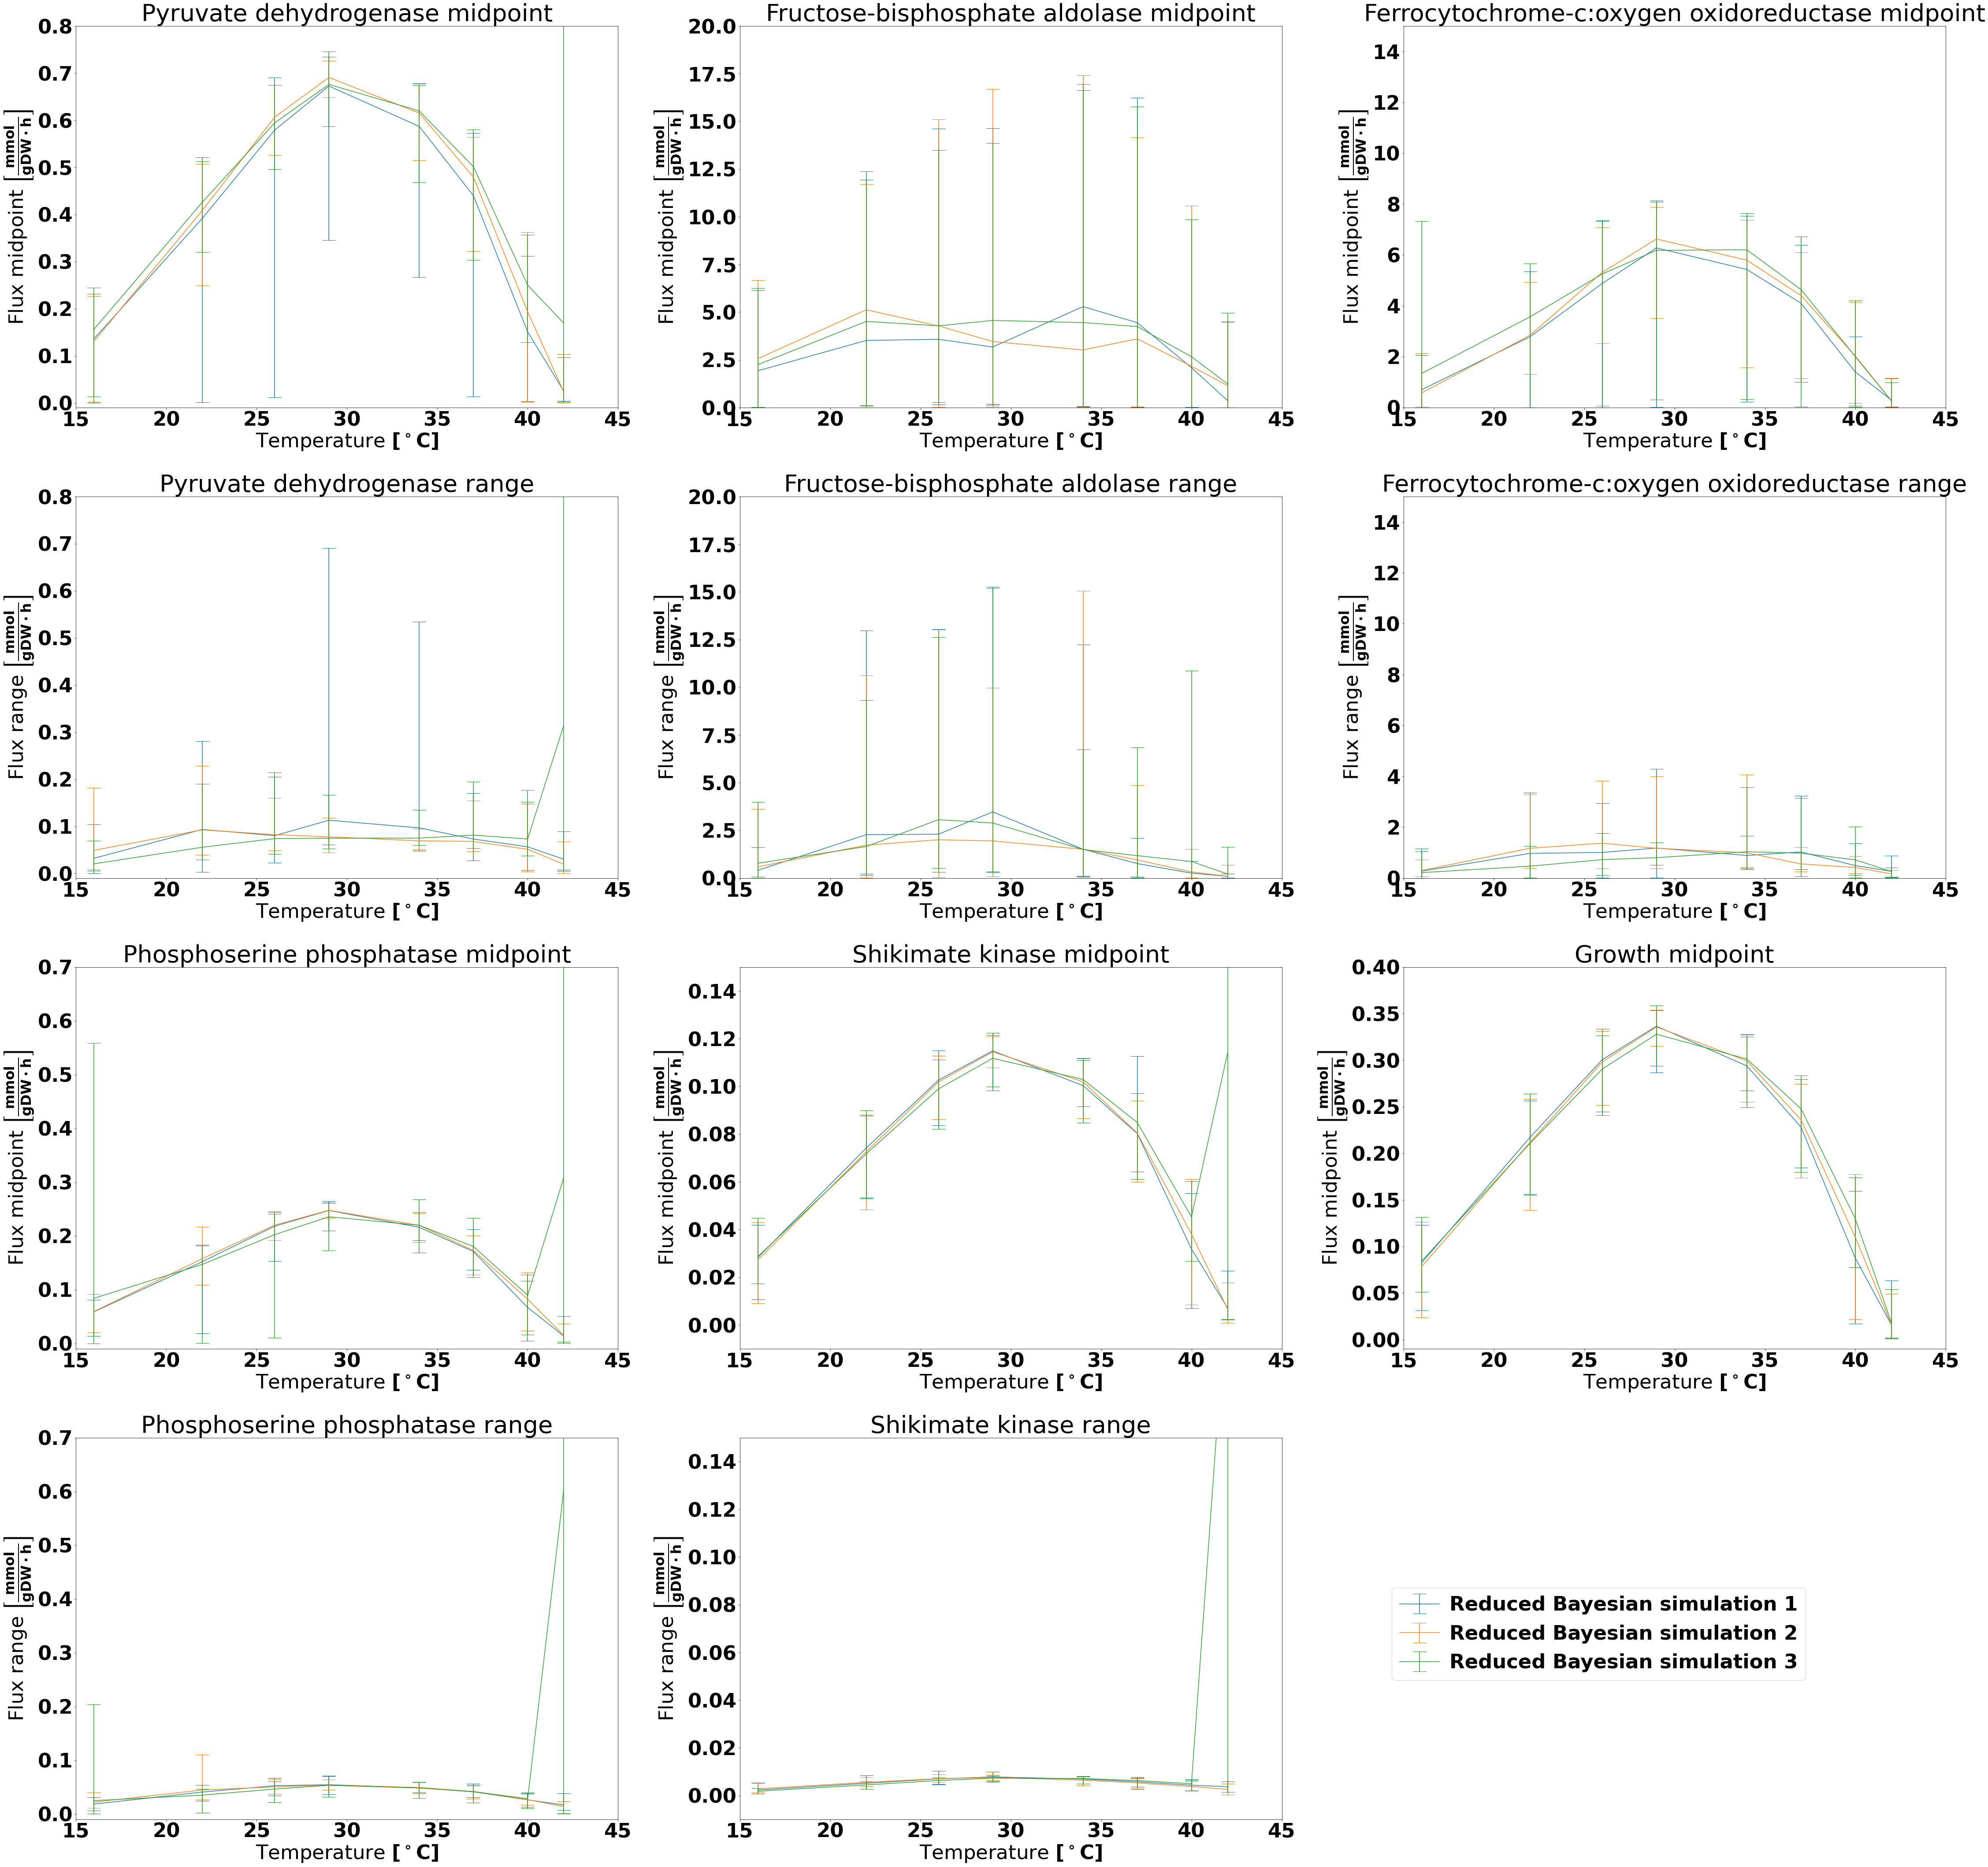

In [86]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(simulation,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["simulation"] == simulation) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(simulation=0,reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Reduced Bayesian simulation 1")
        extract_results_and_plot(simulation=1,reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Reduced Bayesian simulation 2")
        extract_results_and_plot(simulation=2,reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Reduced Bayesian simulation 3")
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/reduced_aerobic_fva.pdf")

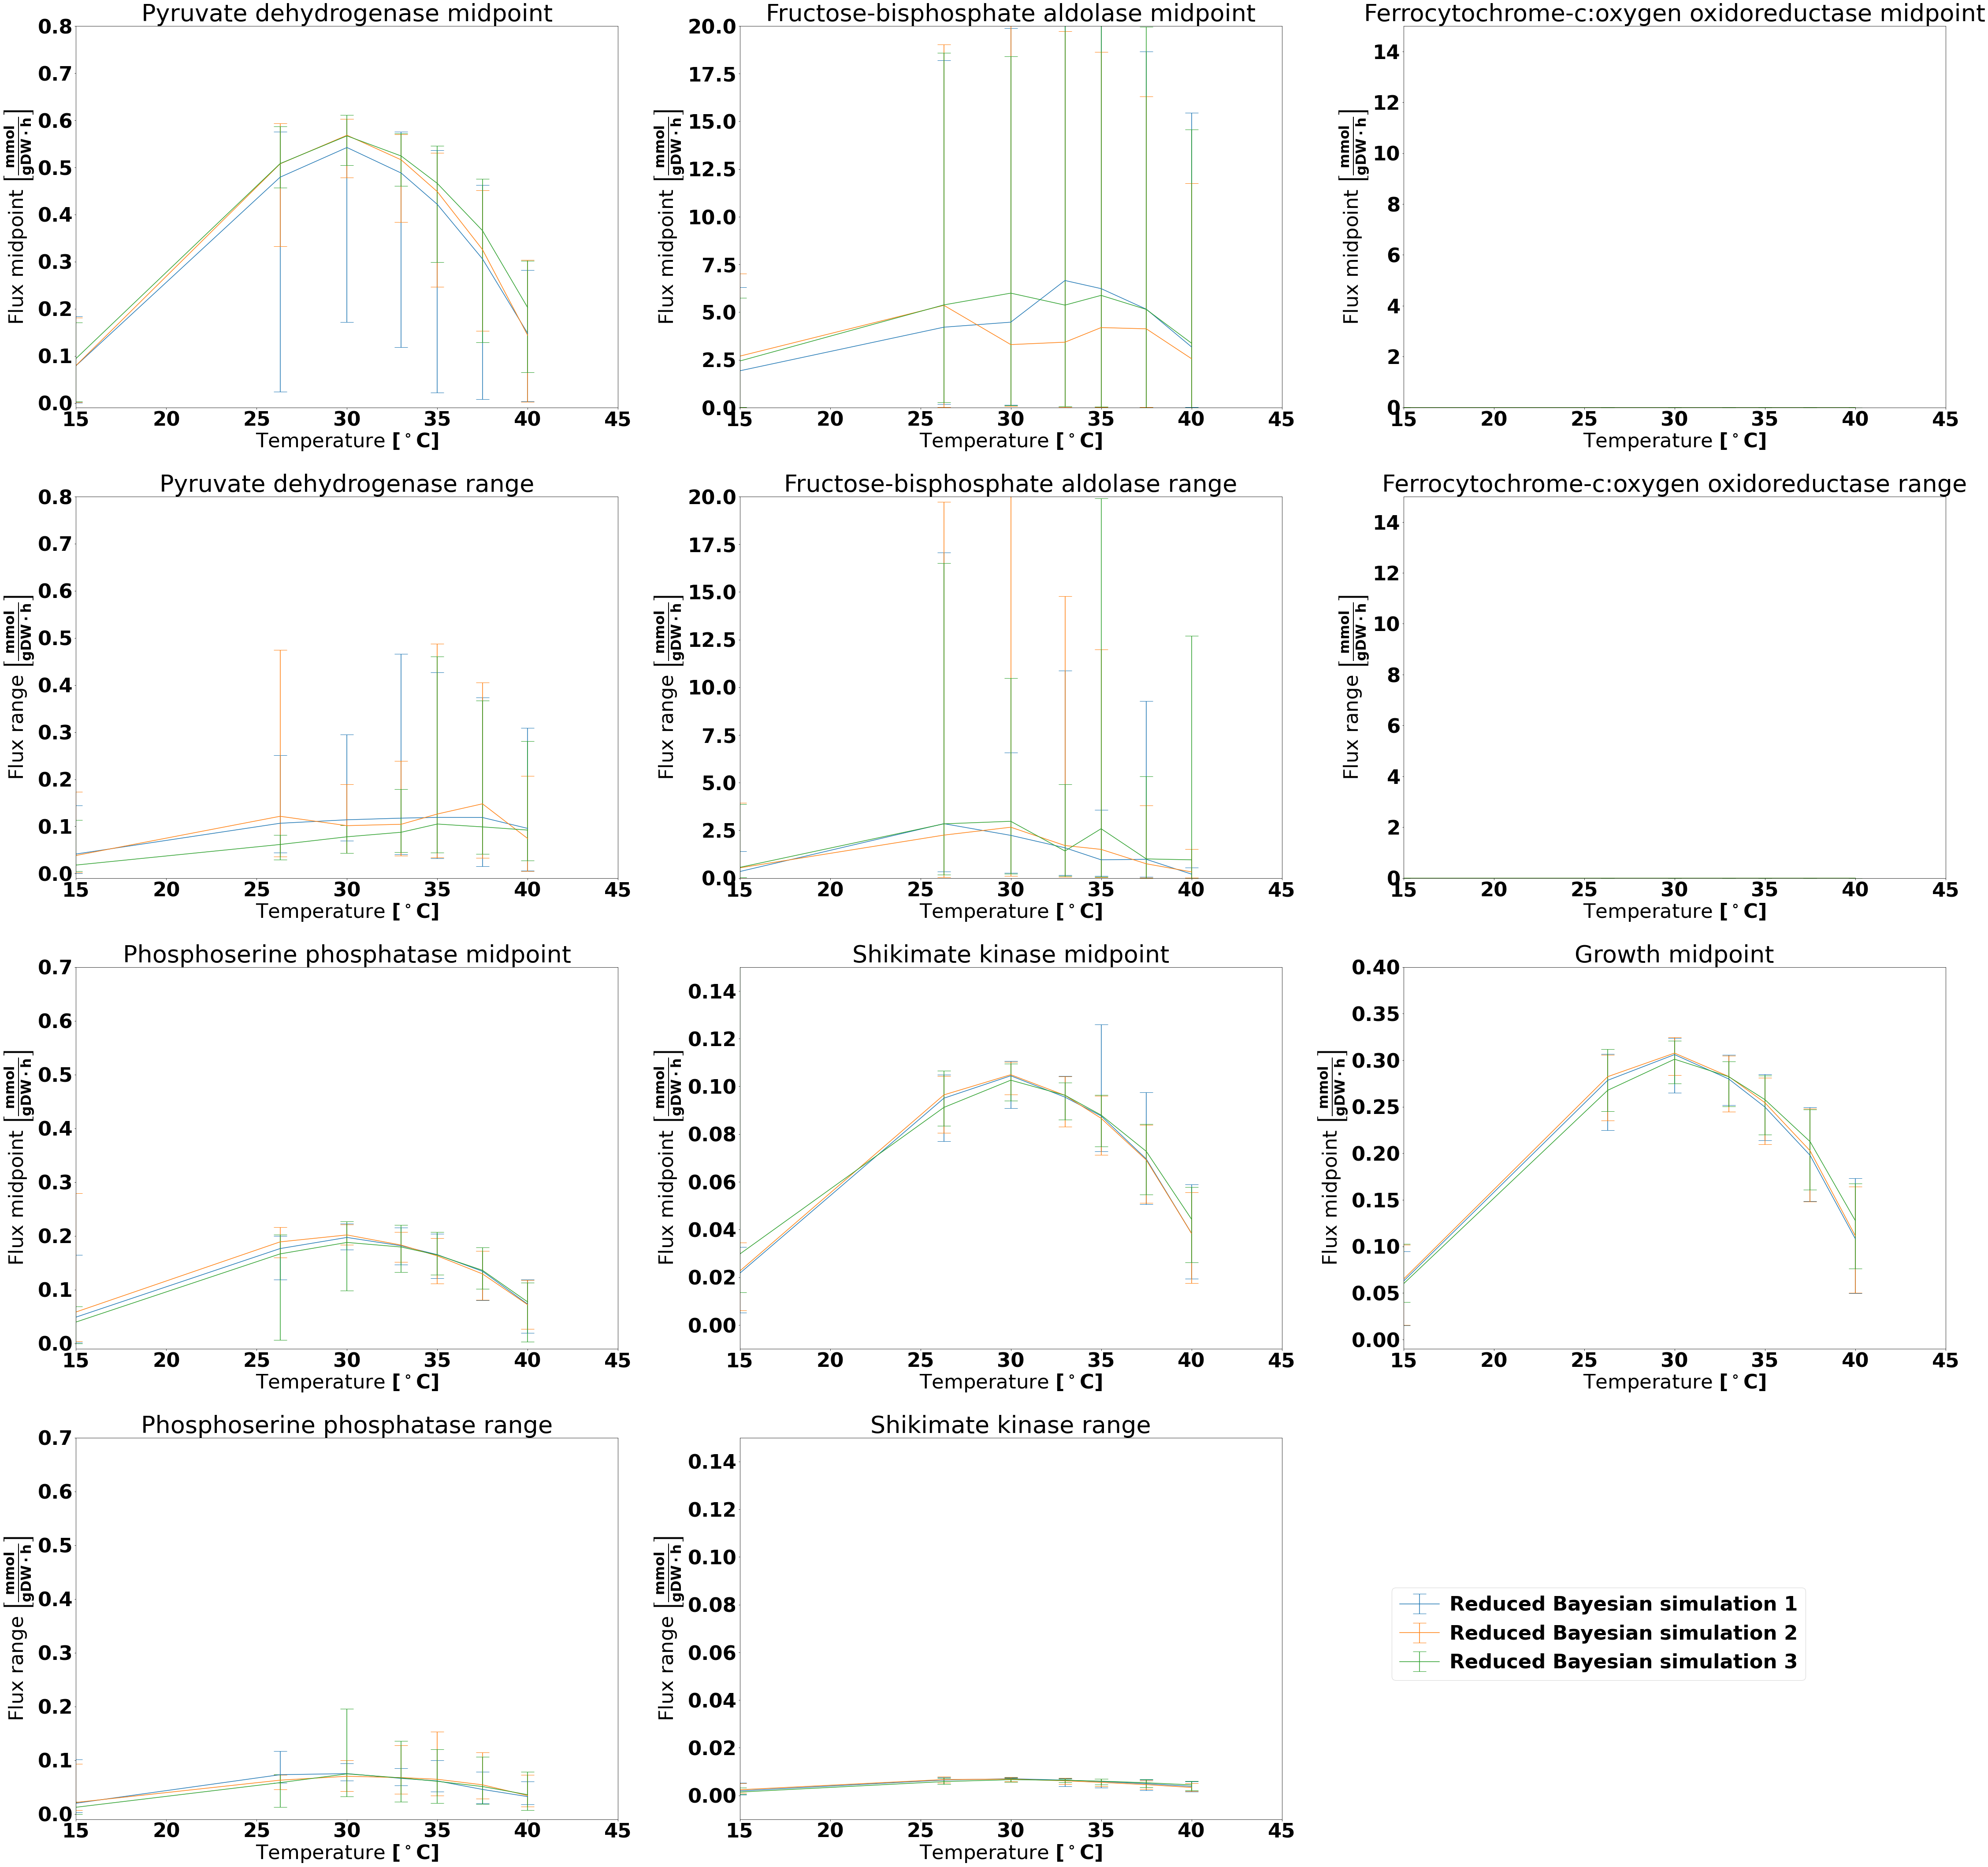

In [87]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(simulation,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["simulation"] == simulation) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(simulation=0,reaction=reaction, what=what, linestyle="solid",condition="anaerobic", label = "Reduced Bayesian simulation 1")
        extract_results_and_plot(simulation=1,reaction=reaction, what=what, linestyle="solid",condition="anaerobic", label = "Reduced Bayesian simulation 2")
        extract_results_and_plot(simulation=2,reaction=reaction, what=what, linestyle="solid",condition="anaerobic", label = "Reduced Bayesian simulation 3")
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/reduced_anaerobic_fva.pdf")

# Results of evolutionary algorithm

In [3]:
evo_model_frame = load_pickle("../results/crowdingDE/distance_frame.pkl")

In [4]:
evo_model_frame

scaling_factor  crossover_prob  simulation  \
0              0.5           0.900           0   
1              0.5           0.900           1   
2              0.5           0.990           0   
3              0.5           0.990           1   
4              0.5           0.999           0   
5              0.5           0.999           1   
6              1.0           0.900           0   
7              1.0           0.900           1   
8              1.0           0.990           0   
9              1.0           0.990           1   
10             1.0           0.999           0   
11             1.0           0.999           1   

                                             outfile  random_seed  \
0     ../results/crowdingDE/smcevo_gem_0.5_0.9_0.pkl        41860   
1     ../results/crowdingDE/smcevo_gem_0.5_0.9_1.pkl        96913   
2    ../results/crowdingDE/smcevo_gem_0.5_0.99_0.pkl         6001   
3    ../results/crowdingDE/smcevo_gem_0.5_0.99_1.pkl        77881   
4   ../results/crowdingDE/smcevo_gem_0.5_0.999_0.pkl        37828   
5   ../results/crowdingDE/smcevo_gem_0.5_0.999_1.pkl        59502   
6     ../results/crowdingDE/smcevo_gem_1.0_0.9_0.pkl        24830   
7     ../results/crowdingDE/smcevo_gem_1.0_0.9_1.pkl        59462   
8    ../results/crowdingDE/smcevo_gem_1.0_0.99_0.pkl        63018   
9    ../results/crowdingDE/smcevo_gem_1.0_0.99_1.pkl        74349   
10  ../results/crowdingDE/smcevo_gem_1.0_0.999_0.pkl        23651   
11  ../results/crowdingDE/smcevo_gem_1.0_0.999_1.pkl        98558   

                                        all_distances  \
0   [3.0069485435030137, 2.053430550039095, 0.8111...   
1   [469.9145290881817, -0.4839632085190048, 1.337...   
2   [2.7074425492095813, 0.9385518380869181, 3.047...   
3   [1.9336398110843498, 2.9428001305066394, 2.651...   
4   [2.2855795805665764, 232367676065.0288, 1.4357...   
5   [0.9787807930022069, -0.6294587728993042, 2.53...   
6   [0.16674268263549802, 0.6659086174598993, 0.53...   
7   [2.5680223468430334, 1.8103400108256702, 0.596...   
8   [2.793908113240032, 1.7840843136873215, 2.4041...   
9   [2.243777402936778, 1.546340706213548, 1.94179...   
10  [3.027319027273574, 3.025143322273478, 3.03354...   
11  [2.3399778109278726, 2.9071472903612143, 2.538...   

                                           population  
0   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
1   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
2   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
3   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
4   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
5   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
6   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
7   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
8   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
9   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
10  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
11  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...

In [30]:
entry = evo_model_frame.loc[11]
final_population = entry["population"][-1]
final_distances = [entry["all_distances"][i] for i in final_population]
np.percentile(final_distances,[1,50,99])

array([-0.93540126,  0.14800567,  3.04754868])

In [5]:
def plot_convergence_evo(distances, maxiter, populations, label = None):
    distance_array = -np.array(distances)
    yp = np.vstack([np.percentile(distance_array[population],[5,50,95]) for population in populations[0:maxiter]])
    plt.plot(np.arange(yp.shape[0]),yp[:,1], label = label)
    plt.fill_between(np.arange(yp.shape[0]),yp[:,0],yp[:,2],alpha=0.5)

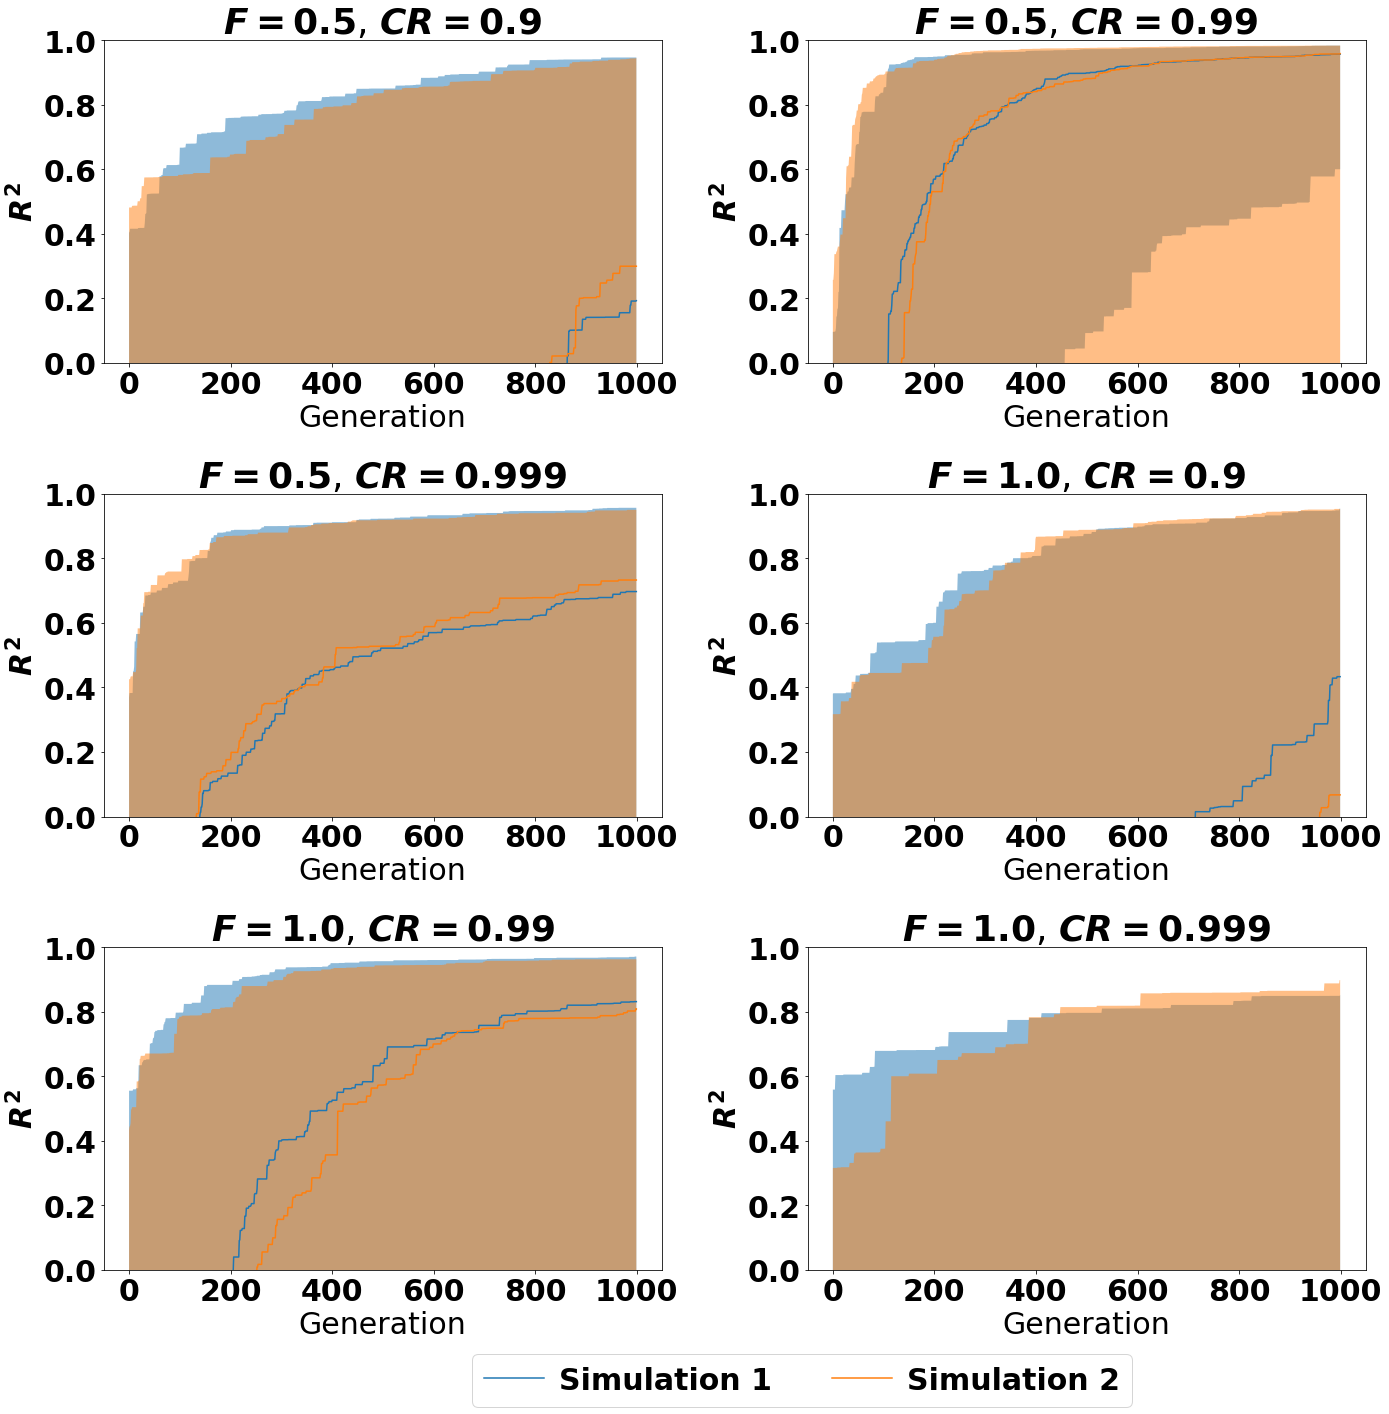

In [21]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
maxiter = 1000
plt.figure(figsize=(20,20))
crossover_prob_values = np.unique(evo_model_frame["crossover_prob"])
scaling_factor_values = np.unique(evo_model_frame["scaling_factor"])
subplot_order = dict(map(reversed,enumerate(itertools.product(scaling_factor_values,crossover_prob_values),start=1)))
for _, entry in evo_model_frame.iterrows():
    scaling_factor = entry["scaling_factor"]
    crossover_prob = entry["crossover_prob"]
    simulation = entry["simulation"]
    populations = entry["population"]
    # plt.subplot(2,2,i)
    distances = entry["all_distances"]
    i = subplot_order[(scaling_factor,crossover_prob)]
    plt.subplot(3,2,i)
    plot_convergence_evo(distances,maxiter=1000,populations=populations, label = f'Simulation {simulation + 1}')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Generation')
    plt.ylabel('$R^2$')
    plt.title(f"$F={scaling_factor}$, $CR={crossover_prob}$")
    plt.tight_layout()
plt.subplots_adjust(bottom=0.10)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/evo_R2.png",dpi=300)
plt.show()

## PCA

In [31]:
evo_PCS,evo_EV = load_pickle("../results/evo_pca.pkl")

In [34]:
evo_combined_df_metadata = load_pickle("../results/crowdingDE/evo_combined_df_metadata.pkl")

In [37]:
evo_combined_df_metadata

particle_ID        period  frame_ID
0                 1         Prior         0
1                 2         Prior         0
2                 3         Prior         0
3                 5         Prior         0
4                 6         Prior         0
...             ...           ...       ...
498093        64077  Intermediate        11
498094        64091  Intermediate        11
498095        64092  Intermediate        11
498096        64093  Intermediate        11
498097        64096  Intermediate        11

[498098 rows x 3 columns]

In [38]:
frame_ID = evo_combined_df_metadata["frame_ID"].to_numpy()
particle_id = evo_combined_df_metadata["particle_ID"].to_numpy()
period = evo_combined_df_metadata["period"].to_numpy()
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [61]:
scaling_factor_values = np.unique(evo_model_frame["scaling_factor"])
crossover_prob_values = np.unique(evo_model_frame["crossover_prob"])
lookup_frame = evo_model_frame.set_index(keys=["scaling_factor","crossover_prob","simulation"])
lookup_frame["frame_ID"] = range(lookup_frame.shape[0])

In [62]:
evo_model_frame

scaling_factor  crossover_prob  simulation  \
0              0.5           0.900           0   
1              0.5           0.900           1   
2              0.5           0.990           0   
3              0.5           0.990           1   
4              0.5           0.999           0   
5              0.5           0.999           1   
6              1.0           0.900           0   
7              1.0           0.900           1   
8              1.0           0.990           0   
9              1.0           0.990           1   
10             1.0           0.999           0   
11             1.0           0.999           1   

                                             outfile  random_seed  \
0     ../results/crowdingDE/smcevo_gem_0.5_0.9_0.pkl        41860   
1     ../results/crowdingDE/smcevo_gem_0.5_0.9_1.pkl        96913   
2    ../results/crowdingDE/smcevo_gem_0.5_0.99_0.pkl         6001   
3    ../results/crowdingDE/smcevo_gem_0.5_0.99_1.pkl        77881   
4   ../results/crowdingDE/smcevo_gem_0.5_0.999_0.pkl        37828   
5   ../results/crowdingDE/smcevo_gem_0.5_0.999_1.pkl        59502   
6     ../results/crowdingDE/smcevo_gem_1.0_0.9_0.pkl        24830   
7     ../results/crowdingDE/smcevo_gem_1.0_0.9_1.pkl        59462   
8    ../results/crowdingDE/smcevo_gem_1.0_0.99_0.pkl        63018   
9    ../results/crowdingDE/smcevo_gem_1.0_0.99_1.pkl        74349   
10  ../results/crowdingDE/smcevo_gem_1.0_0.999_0.pkl        23651   
11  ../results/crowdingDE/smcevo_gem_1.0_0.999_1.pkl        98558   

                                        all_distances  \
0   [3.0069485435030137, 2.053430550039095, 0.8111...   
1   [469.9145290881817, -0.4839632085190048, 1.337...   
2   [2.7074425492095813, 0.9385518380869181, 3.047...   
3   [1.9336398110843498, 2.9428001305066394, 2.651...   
4   [2.2855795805665764, 232367676065.0288, 1.4357...   
5   [0.9787807930022069, -0.6294587728993042, 2.53...   
6   [0.16674268263549802, 0.6659086174598993, 0.53...   
7   [2.5680223468430334, 1.8103400108256702, 0.596...   
8   [2.793908113240032, 1.7840843136873215, 2.4041...   
9   [2.243777402936778, 1.546340706213548, 1.94179...   
10  [3.027319027273574, 3.025143322273478, 3.03354...   
11  [2.3399778109278726, 2.9071472903612143, 2.538...   

                                           population  
0   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
1   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
2   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
3   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
4   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
5   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
6   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
7   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
8   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
9   [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
10  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...  
11  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...

In [64]:
lookup_frame.index

MultiIndex([(0.5,   0.9, 0),
            (0.5,   0.9, 1),
            (0.5,  0.99, 0),
            (0.5,  0.99, 1),
            (0.5, 0.999, 0),
            (0.5, 0.999, 1),
            (1.0,   0.9, 0),
            (1.0,   0.9, 1),
            (1.0,  0.99, 0),
            (1.0,  0.99, 1),
            (1.0, 0.999, 0),
            (1.0, 0.999, 1)],
           names=['scaling_factor', 'crossover_prob', 'simulation'])

In [43]:
def find_generation_particles(df,generation):
    res = []
    for frame_ID, particle_ID in evo_combined_df_metadata[["frame_ID","particle_ID"]].itertuples(index=False):
        frame_generation = evo_model_frame.loc[frame_ID,"population"][generation]
        res.append(particle_ID in frame_generation)
    return res
    

first_generation_idxs = np.flatnonzero(find_generation_particles(evo_combined_df_metadata,0))
final_generation_idxs = np.flatnonzero(find_generation_particles(evo_combined_df_metadata,-1))
generation_idxs = {"First": first_generation_idxs, "Final": final_generation_idxs, "Intermediate": np.setdiff1d(range(evo_combined_df_metadata.shape[0]),np.union1d(first_generation_idxs,final_generation_idxs))}

In [120]:
thinning_rng = np.random.default_rng(3052)
plt.figure(figsize=(25,25))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
marker_dict = {0: 'o', 1: "v"} # Based on simulation number
i = 1
hyperparameter_combinations = itertools.product(scaling_factor_values,crossover_prob_values)
for i, (scaling_factor, crossover_prob) in enumerate(hyperparameter_combinations, start=1):
    plt.subplot(3,2,i)
    for simulation in range(2):
        frame_to_choose = lookup_frame.loc[(scaling_factor,crossover_prob,simulation)]
        this_frame_ID = frame_to_choose["frame_ID"]
        label_idxs = np.flatnonzero(frame_ID == this_frame_ID)
        marker = marker_dict[simulation]
        this_idxs = {generation: np.intersect1d(generation_idxs[generation], label_idxs) for generation in ["First", "Intermediate", "Final"]}
        this_idxs["First"] = thinning_rng.choice(this_idxs["First"],size=min(len(this_idxs["First"]),1000),replace=False)
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=min(this_idxs["Intermediate"],10000),replace=False)
        this_idxs["Final"] = thinning_rng.choice(this_idxs["Final"],size=min(len(this_idxs["Final"]),10000),replace=False)
        print(label_idxs.shape)
        # plt.scatter(evo_PCS[:,0],evo_PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(evo_PCS[this_idxs['First'],0],evo_PCS[this_idxs['First'], 1],edgecolors='#1f78b4',label='First',
                    marker=marker,facecolors='none',s=100)
        plt.scatter(evo_PCS[this_idxs["Intermediate"],0],evo_PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=1,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(evo_PCS[this_idxs['Final'],0],evo_PCS[this_idxs['Final'], 1],
                    edgecolors='#fc8d59',label='Final',marker=marker, facecolors='none',s=100)
        plt.xlabel('PC1 ({:.2f}%)'.format(evo_EV[0]*100))
        plt.ylabel('PC2 ({:.2f}%)'.format(evo_EV[1]*100))
        plt.xticks(np.arange(-40,80,20))
        plt.yticks(np.arange(-20,50,10))
        plt.xlim((-21,51))
        plt.ylim((-21,41))
        plt.title(f"$F={scaling_factor}$, $CR={crossover_prob}$")
        plt.tight_layout()
        colors = ['#1f78b4', 'grey', '#fc8d59']

f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_generation = [f("s", color) for color in colors]
handles_simulation = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_generation, ["First generation", "Intermediate generations", "Final generation"], loc=(1.1,1), framealpha=1, handletextpad=-.5)
legend_simulation = plt.legend(handles_simulation, [f"Simulation {i + 1}" for i in range(2)], loc=(1.1,.3), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_simulation)
# plt.savefig("../figures/evo_pca.png",dpi=400)
plt.show()

(58422,)
(58921,)
(56226,)
(55115,)
(25738,)
(26478,)
(58119,)
(56562,)
(38632,)
(39708,)
(12326,)
(11851,)


## FVA

In [78]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

In [80]:
aggregated_fva_res = load_pickle("../results/crowdingDE/evo_aggregated_fva_res.pkl")
aggregated_fva_res.reset_index(inplace=True)

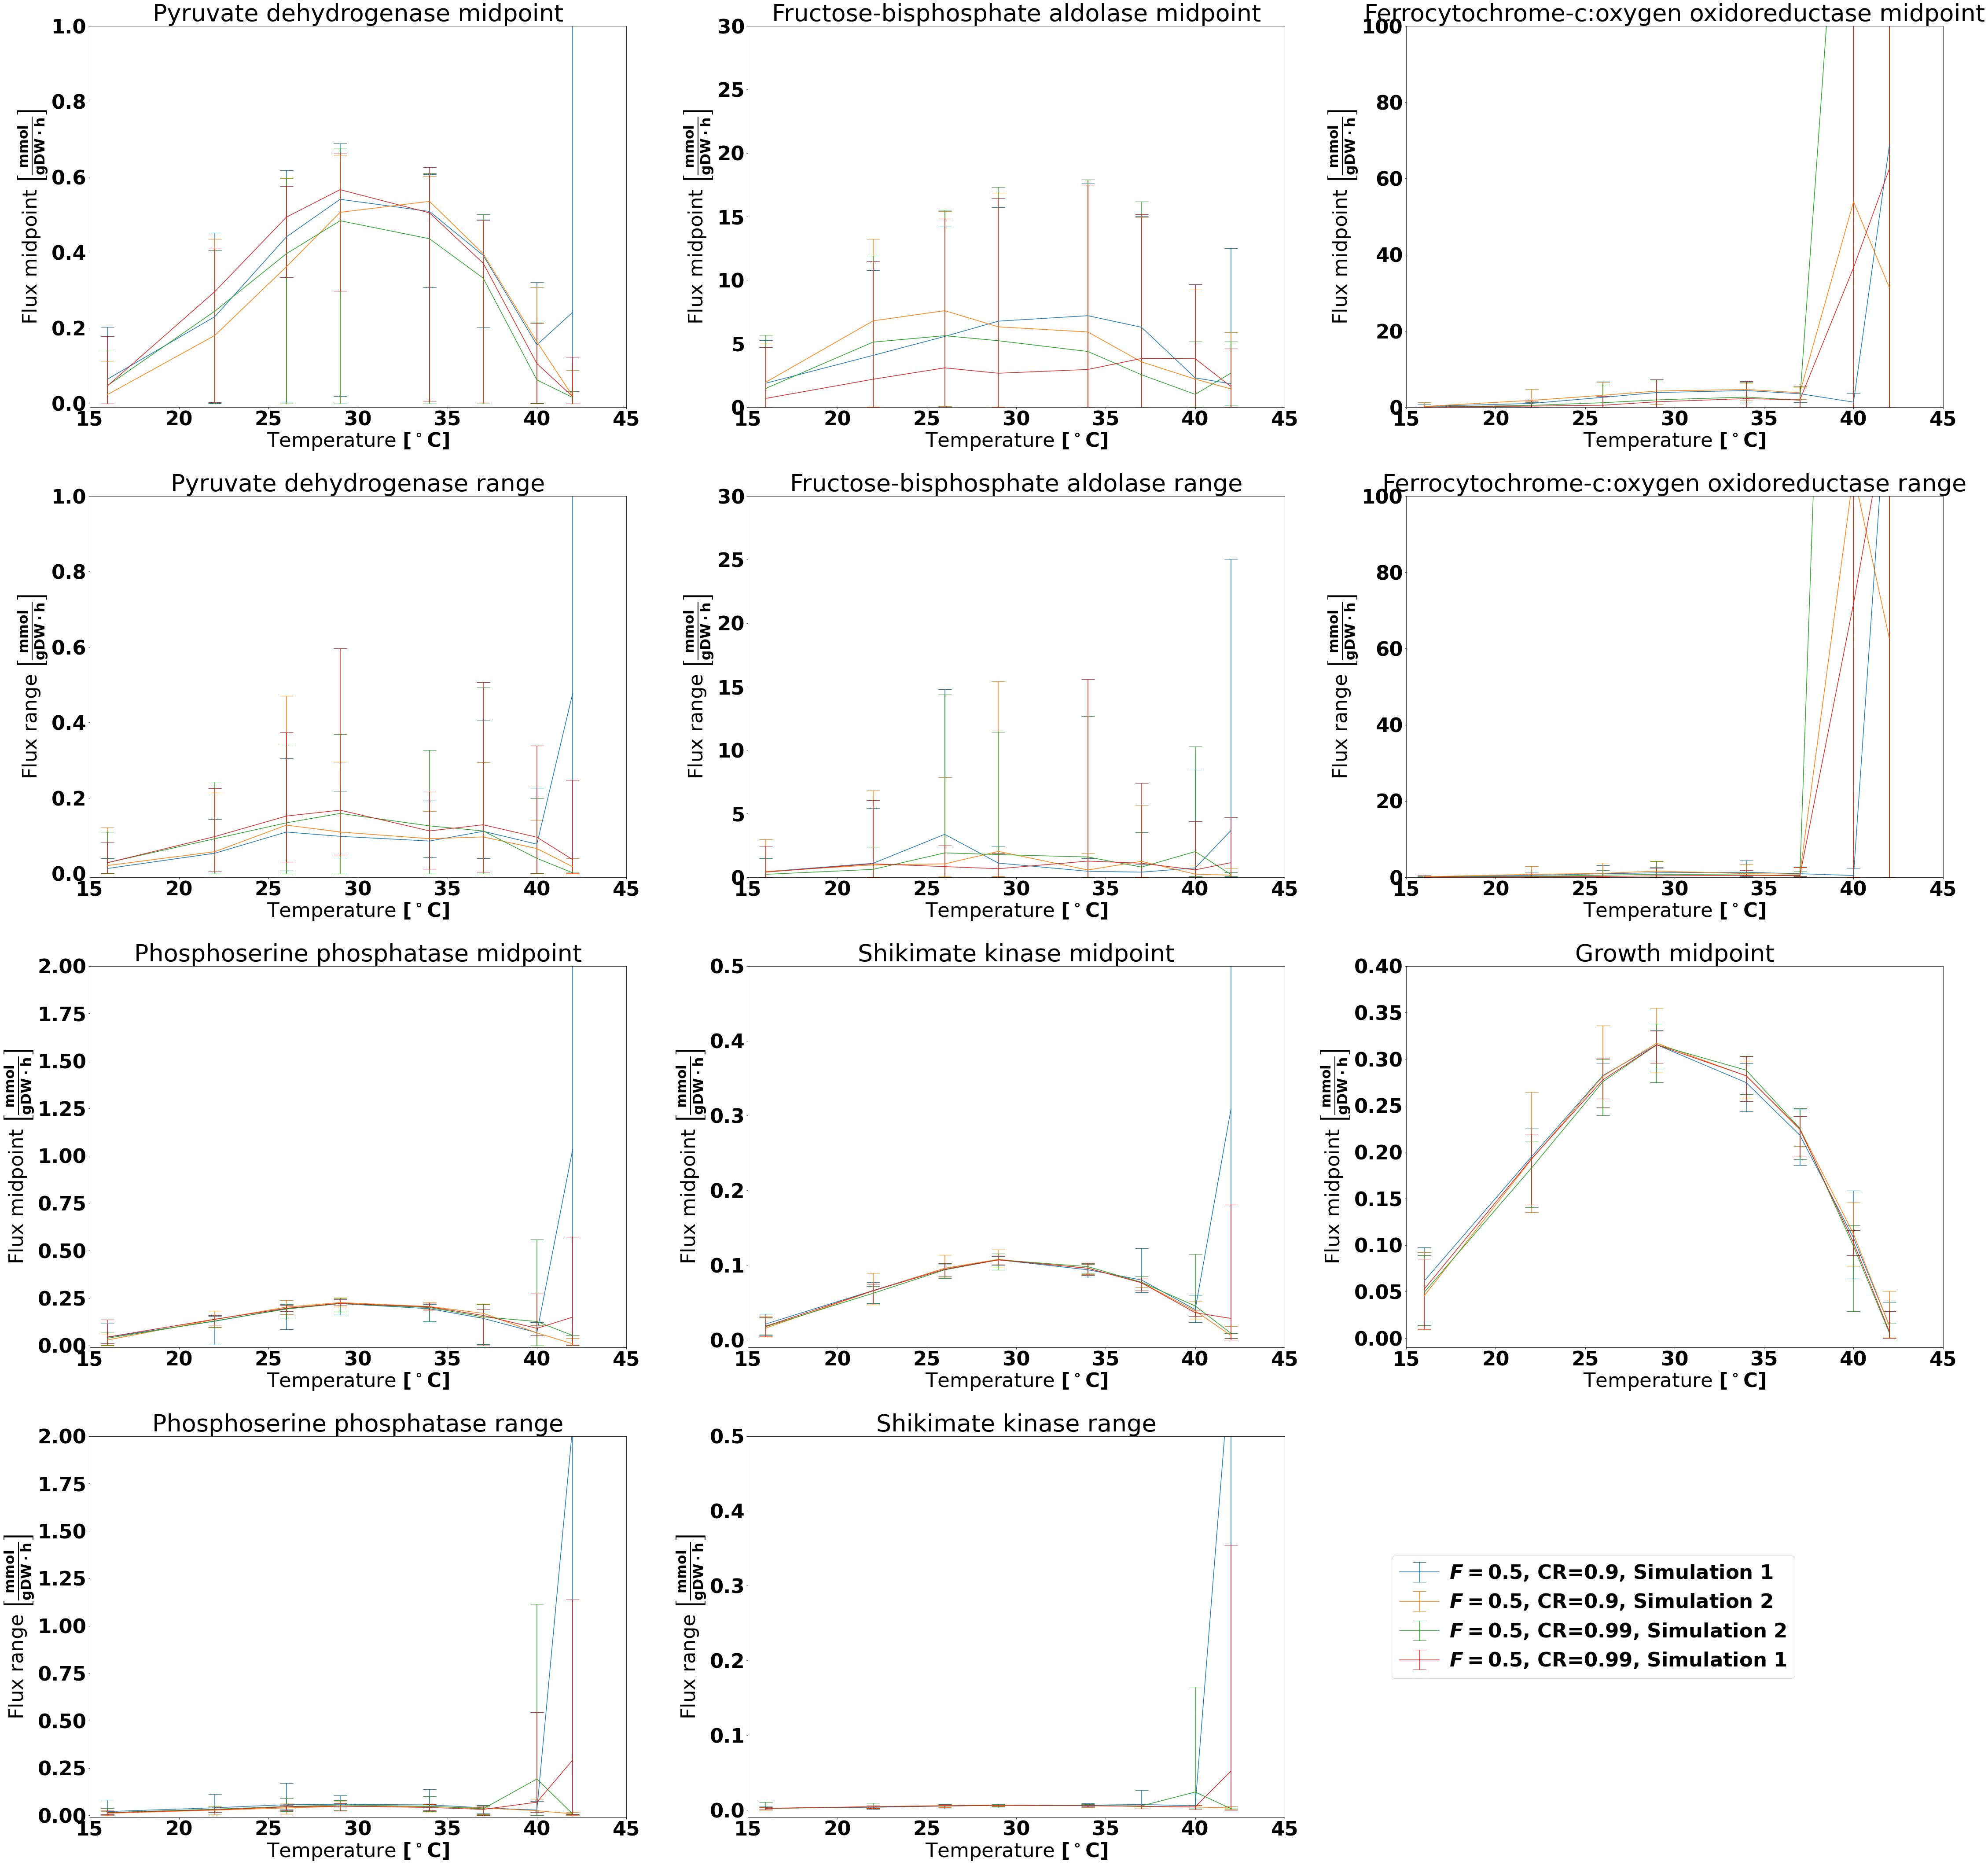

In [117]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(simulation,reaction,scaling_factor,crossover_prob, what, linestyle,condition="aerobic",label=None):
    if label is None:
        label = f"$F={scaling_factor}$, CR={crossover_prob}, Simulation {simulation+1}"
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["simulation"] == simulation) & (df["reaction"] == react_id) & (df["condition"] == condition) &
                                                                                     (df["scaling_factor"] == scaling_factor) & (df["crossover_prob"] == crossover_prob)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 1, "FBA": 30, "FCO": 100, "PSP": 2, "SHK": 0.5, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(simulation=0,scaling_factor=0.5,crossover_prob=0.9,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=1,scaling_factor=0.5,crossover_prob=0.9,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=1,scaling_factor=0.5,crossover_prob=0.99,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=0,scaling_factor=0.5,crossover_prob=0.99,reaction=reaction, what=what, linestyle="solid")
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/evo_aerobic_fva.pdf")

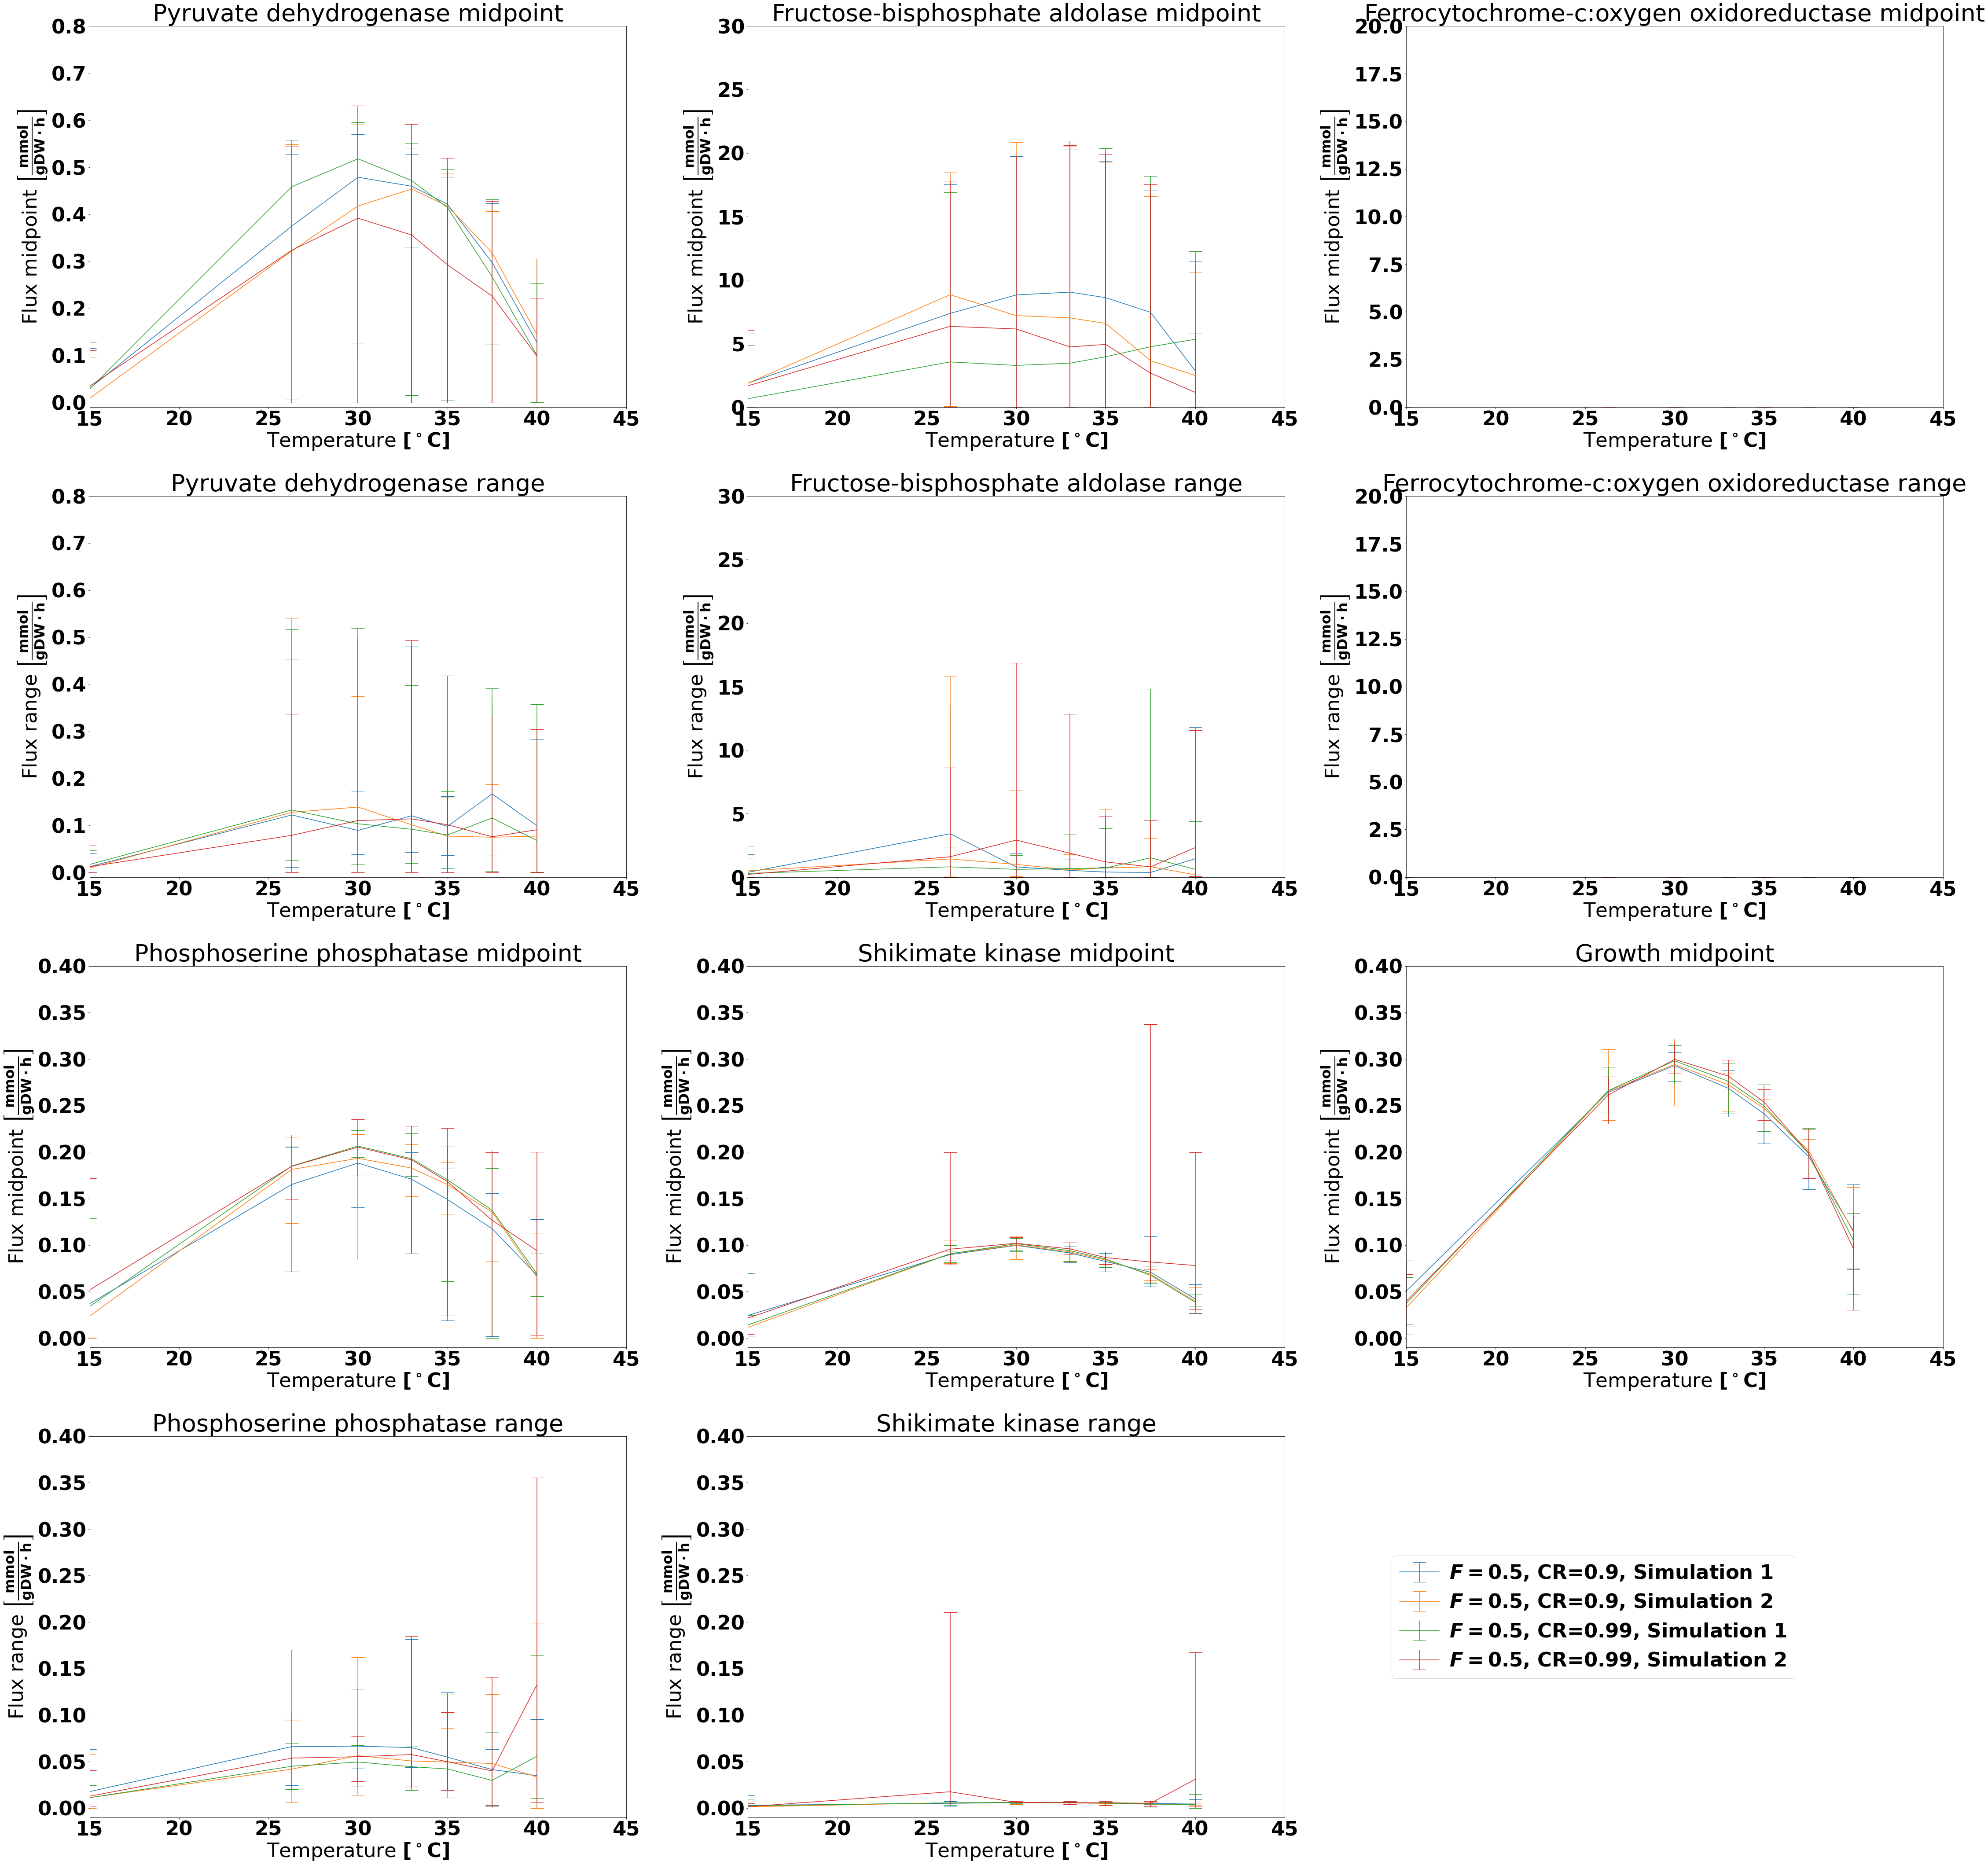

In [115]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(simulation,reaction,scaling_factor,crossover_prob, what, linestyle,condition="anaerobic",label=None):
    if label is None:
        label = f"$F={scaling_factor}$, CR={crossover_prob}, Simulation {simulation+1}"
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["simulation"] == simulation) & (df["reaction"] == react_id) & (df["condition"] == condition) &
                                                                                     (df["scaling_factor"] == scaling_factor) & (df["crossover_prob"] == crossover_prob)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 30, "FCO": 20, "PSP": 0.4, "SHK": 0.4, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(simulation=0,scaling_factor=0.5,crossover_prob=0.9,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=1,scaling_factor=0.5,crossover_prob=0.9,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=0,scaling_factor=0.5,crossover_prob=0.99,reaction=reaction, what=what, linestyle="solid")
        extract_results_and_plot(simulation=1,scaling_factor=0.5,crossover_prob=0.99,reaction=reaction, what=what, linestyle="solid")
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/evo_anaerobic_fva.pdf")